# <font color='black'><h2 align="center">Lost in Translation</h2></font> <h2 align="center">*__Raúl Sánchez Enríquez__*</h2> <h3 align="center">*__September 12, 2020__*</h3>

<img src="https://www.python.org/static/img/python-logo.png" alt="python" style="width: 100px; float: auto;"/>
<br>
<a href = "https://nachocarnes.es"><img src="https://nachocarnes.es/wp-content/uploads/2018/04/ejWGXui6_400x400.png" alt="kschool" style="width: 100px; float: right;"/></a>


*__- Sales representatives require relevant information to address a customer and build rapport.This has a deep impact on customer experience.__*

*__- This work aims to reduce the gap between a model prediction and the information required for Sales representatives to address a customer (Explanation through Explainability).__*

<a class="anchor" id="index-bullet"></a> 
<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

* [1. Data preparation for analysis and pre-modeling](#first-bullet)
    - [Download raw data](#0.0-bullet)
    - [1.1 Categorical features preparation](#1.1-bullet)
    - [1.2 Numerical features preparation](#1.2-bullet)
    - [1.3 Merge categ and numerical files ](#1.3-bullet)
* [2 Process data for visualization](#second-bullet)
    - [2.1 Categorical features visualization](#2.1-bullet)
    - [2.1.1 Categorical features visualization (bar plot)](#2.1.1-bullet)
    - [2.1.2 Categorical features visualization (bar plot-base 100)](#2.1.2-bullet)
    - [2.2 Numercial visualization ](#2.2-bullet)
    - [2.3 Customers Geolocalization ](#2.3-bullet)
* [3 Feature selection](#third-bullet)
    - [3.1 Heatmap](#3.1-bullet)
    - [3.2 Top varible absolute correlation](#3.2-bullet)
    - [3.3 Top correlated features with the dependent variable](#3.3-bullet)
    - [3.4 Backward feature elimination ](#3.4-bullet)
* [4 Outliers](#forth-bullet)
    - [4.1 IQR (mean)](#4.1-bullet)
    - [4.2 zScore (Standard deviation)](#4.2-bullet)
* [5 Models  approach](#fifth-bullet)
    - [5.1 Dataset normalization | balanced| train,test & validation](#5.1-bullet)
    - [5.2 Visualization unbalanced and balanced dataset)](#5.2-bullet)
* [6 Models](#sixth-bullet)
    - [6.1 Logistic Regression](#6.1-bullet)
    - [6.2 Decision Tree Classifier](#6.2-bullet)
    - [6.3 Random forest classifier](#6.3-bullet)
    - [6.4 XGBBoost](#6.4-bullet)
    - [6.5 Stacking ensemble Model](#6.5-bullet)
* [7 Business Plan](#seventh-bullet)
    - [7.1 Initial approach and basic information](#7.1-bullet)
    - [7.2 Implementing LIME to generate local interpretations of black-box](#7.2-bullet)


### Libraries

In [1]:
%autosave 240

Autosaving every 240 seconds


In [67]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from seaborn import kdeplot
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from mpl_toolkits.axes_grid.inset_locator import inset_axes
'''need to install first folium :conda install -c conda-forge folium'''
import folium  
import geopandas as gpd

# feature selection
import statsmodels.api as sm
# Balance
'''conda install -c conda-forge imbalanced-learn'''
from collections import Counter
from imblearn.over_sampling import SMOTENC
from sklearn.datasets import make_classification
from imblearn.datasets import make_imbalance

from sklearn.model_selection import train_test_split
from sklearn.tree.export import export_text
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn import tree

from sklearn.linear_model import LogisticRegression
from sklearn import model_selection,metrics

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,auc,confusion_matrix,classification_report, f1_score

from numpy import mean, arange, argmax
from sklearn.model_selection import RepeatedStratifiedKFold

'''conda install -c anaconda py-xgboost'''
from xgboost import XGBClassifier


%matplotlib inline

#Stacking ensemble model
import mlens
from itertools import combinations
from mlens.ensemble import SuperLearner
from mlxtend.classifier import StackingClassifier

# LIME

# import Explainer function from lime_tabular module of lime library
from lime.lime_tabular import LimeTabularExplainer



# 1.  Data preparation for analysis and pre-modeling <a class="anchor" id="first-bullet"></a>
[table of contents](#index-bullet)

### Download raw data <a class="anchor" id="0.0-bullet"></a>
[table of contents](#index-bullet)

In [3]:
# I downloaded the info from SAS. 
# I chuncksized it to upload it. 
warnings.simplefilter('ignore')
# For automation purpose i am going to look for the files path

pd.set_option('display.max_columns',50)

'''os.path.abspath  The path module suitable for 
the operating system Python is running on, and therefore usable 
for local paths.Return a normalized absolutized version of the pathname path
https://docs.python.org/2/library/os.path.html''' 
'''Original dataframe called Raw_data_TFM.CSV'''

mother_file_path = os.path.abspath("Raw_data_TFM.CSV") 

mother_file = pd.read_csv(mother_file_path,sep=';',chunksize =200000,low_memory=False)

# i read the file 

file = mother_file
''' call the file outside the loop'''
all_chunks =pd.DataFrame()

for i,chunk in enumerate(file):
    print(i,len(all_chunks))
    all_chunks = all_chunks.append(chunk)
    all_chunks.drop_duplicates(inplace =True)

# Record it

all_chunks.to_csv('Total_clients_ini.csv',sep= ';',index =False)


Total_clients_ini= pd.read_csv('Total_clients_ini.csv',sep=';',squeeze=True)

# filter non residents to avoid noise. 

total_clients_file_ini = Total_clients_ini[(Total_clients_ini['resi_country']== 'ES') &
                                           (Total_clients_ini['codseg']!= 'BC')]
# Drop features not relevant for this study
 
total_clients_file_ini.drop(['branch','codine','nat_country', 'resi_country','country',
                                                     'cod1','cod2',], axis=1,inplace =True)
total_clients_file_ini.shape

0 0
1 200000


(395937, 44)

In [4]:
'''sample() is an inbuilt function of random module in Python that returns 
a particular length list of items chosen from the sequence i.e. list, tuple,
string or set. Used for random sampling without replacement.
https://www.geeksforgeeks.org/python-random-sample-function/'''

total_clients_file_ini.sample(5)

gender  age  studies work_type marital_status codseg  cpper cprovper  \
344543      V   50        5         P              C     CN   3204       46   
16612       V   64        2         A              S     PR  28220       28   
212961      H   34        2         P              S     CN  46014        8   
123513      H   94        5         J              C     PR   6006       45   
95151       V   94        3         J              C     PI   8150       29   

        clocaper autonper population_cmun  disporent_cmun  num_cred_cards_0m  \
344543     90620       17            7855         19918.0                0.0   
16612      90053        1           88430         21931.0                0.0   
212961       112       13       3182981.0         29400.0                1.0   
123513       610       12         27159.0         19265.0                0.0   
95151        179       11           59187         19611.0                1.0   

        aveg_amount_cred_card_0m  num_current_acc_0m  \
344543                      0.00                 1.0   
16612                       0.00                 1.0   
212961                     82.02                 2.0   
123513                      0.00                 1.0   
95151                       0.00                 2.0   

       aveg_amount_current_acc_0m  num_invest_funds_0m  \
344543                     -70.27                  0.0   
16612                           0                  0.0   
212961                     299.54                  0.0   
123513                    16543.8                  0.0   
95151                      141140                  0.0   

        aveg_amount_invest_funds_0m mortgage  num_stocks_0m  \
344543                          0.0        N            0.0   
16612                           0.0        S            1.0   
212961                          0.0        N            0.0   
123513                          0.0        N            0.0   
95151                           0.0        N            1.0   

       aveg_amount_stocks_0m  acc_0m mobile_0m pc_0m tablet_0m  \
344543                     0     4.0         1     0         0   
16612               52,52936     0.0         0     0         0   
212961                     0    13.0       1.0   0.0       0.0   
123513                     0     NaN       NaN   NaN       NaN   
95151                3,41174     0.0         0     0         0   

        national_transfers_0m  transfers_0m  app_par_0m  web_par_0m  \
344543                    0.0           0.0         4.0         0.0   
16612                     0.0           0.0         0.0         0.0   
212961                    2.0           2.0        13.0         0.0   
123513                    NaN           NaN         NaN         NaN   
95151                     0.0           0.0         0.0         0.0   

       amount_cards_0m amount_trfr_0m amount_salarypenr_0m amount_rec_0m  \
344543               0              0                    0     462,94488   
16612         82,44403      787,42656           1041,98256       30,5558   
212961       537,90179        1354,88                    0     818,16014   
123513               0      674,40544            892,42444        48,203   
95151         36,49037       775,6224            1026,3624     464,28476   

       amount_total_cards_0m  num_trfr_0m  num_trfe_0m  num_rec_0m  \
344543                     0          0.0          0.0         2.0   
16612              113,67414          1.0          0.0         2.0   
212961             741,66102          6.0          6.0         9.0   
123513                     0          1.0          0.0         2.0   
95151               50,31306          1.0          0.0         5.0   

        num_card_postpone_payment_3t4t_delta  \
344543                                   0.0   
16612                                    0.0   
212961                                   0.0   
123513                                   0.0   
95151                                    0.0

In [5]:
# place the dependent feature as first column
newdf = total_clients_file_ini[total_clients_file_ini.columns[0:-1]]
newdf_contrata = total_clients_file_ini[total_clients_file_ini.columns[-1:]]
total_clients_file_ini = pd.concat([newdf_contrata, newdf], axis = 1)
total_clients_file_ini.sample(5)

got_loan gender  age  studies work_type marital_status codseg  cpper  \
30254          0      H   42        6         A              S     PR  47007   
208289         0      H   45        2         A              V     PR  28224   
311788         0      V   42        2         A              D     PR  36740   
136061         0      V   66        1         P              S     PR  37004   
216238         0      V   60        2         P              O     CN  39807   

       cprovper  clocaper autonper population_cmun  disporent_cmun  \
30254        46      5714       12            5051         17214.0   
208289        6       814       13       3182981.0         29400.0   
311788       46       300       13       3182981.0         29400.0   
136061       10       135        9         25574.0         22081.0   
216238       28       178        3          220301         23377.0   

        num_cred_cards_0m  aveg_amount_cred_card_0m  num_current_acc_0m  \
30254                 0.0                       0.0                 1.0   
208289                0.0                       0.0                 1.0   
311788                0.0                       0.0                 1.0   
136061                0.0                       0.0                 1.0   
216238                0.0                       0.0                 1.0   

       aveg_amount_current_acc_0m  num_invest_funds_0m  \
30254                           0                  0.0   
208289                     -29.18                  0.0   
311788                    5669.61                  0.0   
136061                      180.6                  0.0   
216238                     305.79                  0.0   

        aveg_amount_invest_funds_0m mortgage  num_stocks_0m  \
30254                           0.0        N            0.0   
208289                          0.0        N            0.0   
311788                          0.0        N            0.0   
136061                          0.0        N            1.0   
216238                          0.0        N            4.0   

       aveg_amount_stocks_0m  acc_0m           mobile_0m                pc_0m  \
30254                      0     1.0                   0                    1   
208289                     0    35.0  0.8571428571428571  0.14285714285714285   
311788                     0    55.0                 1.0                  0.0   
136061              95,26188     NaN                 NaN                  NaN   
216238            4790,40698     3.0                   0                    1   

       tablet_0m  national_transfers_0m  transfers_0m  app_par_0m  web_par_0m  \
30254          0                    0.0           0.0         0.0         1.0   
208289       0.0                    5.0           0.0         1.0        34.0   
311788       0.0                    0.0           0.0        51.0         3.0   
136061       NaN                    NaN           NaN         NaN         NaN   
216238         0                    1.0           0.0         0.0         3.0   

       amount_cards_0m amount_trfr_0m amount_salarypenr_0m amount_rec_0m  \
30254        962,41564     1075,14368           1422,71168       76,9614   
208289       274,14951         252,88               334,63      15,96418   
311788       252,03991     1984,92704           2609,95436     739,69546   
136061               0              0                    0             0   
216238            9,53      920,88224           1218,58124     136,93737   

       amount_total_cards_0m  num_trfr_0m  num_trfe_0m  num_rec_0m  \
30254             1326,98232          1.0          0.0         1.0   
208289             377,99838          1.0          5.0         1.0   
311788             347,51358          4.0          0.0        38.0   
136061                     0          NaN          NaN         NaN   
216238                 13,14          1.0          1.0         3.0   

        num_card_postpone_payment_3t4t_delta  \
30254                      

In [6]:
# Filter and print number of instances with feature got loan value =1 and with got loan =0 
print('Total clientes with loan: ',total_clients_file_ini[total_clients_file_ini.got_loan ==1].shape)
print('Total clientes without loan: ', total_clients_file_ini[total_clients_file_ini.got_loan ==0].shape)

Total clientes with loan:  (7005, 44)
Total clientes without loan:  (388932, 44)


In [7]:
'''column labels of the DataFrame 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html'''

total_clients_file_ini.columns

Index(['got_loan', 'gender', 'age', 'studies', 'work_type', 'marital_status',
       'codseg', 'cpper', 'cprovper', 'clocaper', 'autonper',
       'population_cmun', 'disporent_cmun', 'num_cred_cards_0m',
       'aveg_amount_cred_card_0m', 'num_current_acc_0m',
       'aveg_amount_current_acc_0m', 'num_invest_funds_0m',
       'aveg_amount_invest_funds_0m', 'mortgage', 'num_stocks_0m',
       'aveg_amount_stocks_0m', 'acc_0m', 'mobile_0m', 'pc_0m', 'tablet_0m',
       'national_transfers_0m', 'transfers_0m', 'app_par_0m', 'web_par_0m',
       'amount_cards_0m', 'amount_trfr_0m', 'amount_salarypenr_0m',
       'amount_rec_0m', 'amount_total_cards_0m', 'num_trfr_0m', 'num_trfe_0m',
       'num_rec_0m', 'num_card_postpone_payment_3t4t_delta',
       'aved_amount_postpone_payment_3t4t_delta', 'previous_loans',
       'months_since_loan', 'car_years', 'House_years'],
      dtype='object')

In [8]:
'''This method prints information about a DataFrame including the index
dtype and columns, non-null values and memory usage.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html''' 

total_clients_file_ini.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395937 entries, 0 to 399999
Data columns (total 44 columns):
got_loan                                   395937 non-null int64
gender                                     395937 non-null object
age                                        395937 non-null int64
studies                                    395937 non-null int64
work_type                                  395937 non-null object
marital_status                             395937 non-null object
codseg                                     395937 non-null object
cpper                                      393708 non-null object
cprovper                                   395937 non-null object
clocaper                                   395937 non-null int64
autonper                                   393855 non-null object
population_cmun                            395937 non-null object
disporent_cmun                             395937 non-null float64
num_cred_cards_0m                 

In [9]:
# find number of NaN in each column

total_clients_file_ini.isnull().sum()

got_loan                                        0
gender                                          0
age                                             0
studies                                         0
work_type                                       0
marital_status                                  0
codseg                                          0
cpper                                        2229
cprovper                                        0
clocaper                                        0
autonper                                     2082
population_cmun                                 0
disporent_cmun                                  0
num_cred_cards_0m                             506
aveg_amount_cred_card_0m                        0
num_current_acc_0m                            506
aveg_amount_current_acc_0m                      0
num_invest_funds_0m                           506
aveg_amount_invest_funds_0m                     0
mortgage                                      114


In [10]:
# check for duplicates.
'''Return boolean Series denoting duplicate rows
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html'''

duplicateRowsDF = total_clients_file_ini[total_clients_file_ini.duplicated()]
 
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)


Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [got_loan, gender, age, studies, work_type, marital_status, codseg, cpper, cprovper, clocaper, autonper, population_cmun, disporent_cmun, num_cred_cards_0m, aveg_amount_cred_card_0m, num_current_acc_0m, aveg_amount_current_acc_0m, num_invest_funds_0m, aveg_amount_invest_funds_0m, mortgage, num_stocks_0m, aveg_amount_stocks_0m, acc_0m, mobile_0m, pc_0m, tablet_0m, national_transfers_0m, transfers_0m, app_par_0m, web_par_0m, amount_cards_0m, amount_trfr_0m, amount_salarypenr_0m, amount_rec_0m, amount_total_cards_0m, num_trfr_0m, num_trfe_0m, num_rec_0m, num_card_postpone_payment_3t4t_delta, aved_amount_postpone_payment_3t4t_delta, previous_loans, months_since_loan, car_years, House_years]
Index: []


### 1.1 Categorical features preparation <a class="anchor" id="1.1-bullet"></a>
[table of contents](#index-bullet)

In [11]:
# 1.Create a Dataframe "categorical_file" only with categorical features.

colsToDrop = ['age', 
       'clocaper', 'autonper',
       'population_cmun', 'disporent_cmun', 'num_cred_cards_0m',
       'aveg_amount_cred_card_0m', 'num_current_acc_0m',
       'aveg_amount_current_acc_0m', 'num_invest_funds_0m',
       'aveg_amount_invest_funds_0m', 'num_stocks_0m',
       'aveg_amount_stocks_0m', 'acc_0m', 'mobile_0m', 'pc_0m', 'tablet_0m',
       'national_transfers_0m', 'transfers_0m', 'app_par_0m', 'web_par_0m',
       'amount_cards_0m', 'amount_trfr_0m', 'amount_salarypenr_0m',
       'amount_rec_0m', 'amount_total_cards_0m', 'num_trfr_0m', 'num_trfe_0m',
       'num_rec_0m', 'num_card_postpone_payment_3t4t_delta',
       'aved_amount_postpone_payment_3t4t_delta', 
       'months_since_loan', 'car_years', 'House_years']

categorical_file = total_clients_file_ini.drop(colsToDrop, axis=1)
'''shape is a tuple that gives you an indication of the number of dimensions'''
categorical_file.shape

(395937, 10)

In [12]:
categorical_file.sample(5)

got_loan gender  studies work_type marital_status codseg  cpper  \
197208         0      V        3         J              C     PR  32001   
106977         0      V        3         A              C     PR  12593   
284561         0      V        2         J              S     PR  47185   
289774         0      V        2         J              C     PR  36500   
194163         0      V        5         A              S     PR  18330   

       cprovper mortgage  previous_loans  
197208       48        N               0  
106977       13        N               0  
284561       **        N               0  
289774       35        N               0  
194163       39        N               0

In [13]:
'''transform categorical features '''
warnings.simplefilter('ignore')
# 2. Fill NaN accordingly in preparation to encode them

categorical_file[['mortgage']].fillna('N', inplace = True)
categorical_file[['cpper','cprovper']].fillna('11111', inplace = True)


# 3. Change all categorical variables into dummies 

'''In order to work properlly first you have to change feature 'studies' dtype to object'''

categorical_file['studies'] = categorical_file['studies'].astype('O')

categorical_file_mod_dummies= pd.get_dummies(categorical_file[['gender','studies',
                                                               'work_type','marital_status',
                                                               'codseg','mortgage']])
categorical_file_mod = pd.concat([categorical_file[['got_loan','cpper','cprovper',
                                                    'previous_loans']], categorical_file_mod_dummies], axis=1)

# 4. Replace special values from some features

'''replace() is an inbuilt function in Python programming language that 
returns a copy of the string where all occurrences of a substring is replaced 
with another substring'''

categorical_file_mod['cpper'].replace('********', value='11111',inplace=True)
categorical_file_mod['cpper'].replace('KS', value='11111',inplace=True)
categorical_file_mod['cpper'].replace('dic-00', value='11111',inplace=True)
categorical_file_mod['cpper'].fillna(0, inplace=True)

categorical_file_mod['cprovper'].replace('**', value='11111',inplace=True)
categorical_file_mod[['cpper','cprovper']].fillna( '11111', inplace = True) 
categorical_file_mod.head(5)

got_loan  cpper cprovper  previous_loans  gender_H  gender_V  studies_1  \
0         0  17455        4               0         1         0          0   
1         0   3640       39               0         0         1          1   
2         0  11540       41               0         0         1          1   
3         0  28022    11111               0         0         1          0   
4         0  28232       33               0         0         1          0   

   studies_2  studies_3  studies_4  studies_5  studies_6  work_type_A  \
0          1          0          0          0          0            1   
1          0          0          0          0          0            0   
2          0          0          0          0          0            1   
3          1          0          0          0          0            1   
4          0          1          0          0          0            0   

   work_type_J  work_type_O  work_type_P  marital_status_C  marital_status_D  \
0            0            0            0                 0                 0   
1            0            0            1                 1                 0   
2            0            0            0                 1                 0   
3            0            0            0                 0                 1   
4            0            0            1                 0                 0   

   marital_status_O  marital_status_S  marital_status_V  codseg_CN  codseg_PB  \
0                 0                 1                 0          0          0   
1                 0                 0                 0          1          0   
2                 0                 0                 0          0          0   
3                 0                 0                 0          0          0   
4                 0                 0                 1          1          0   

   codseg_PI  codseg_PR  mortgage_N  mortgage_S  
0          0          1           1           0  
1          0          0           1           0  
2          0          1           1           0  
3          0          1           1           0  
4          0          0           1           0

### 1.2 Numerical features preparation <a class="anchor" id="1.2-bullet"></a>
[table of contents](#index-bullet)

In [14]:
# 1. Recup  the features dropped previouslly. Create a dataframe and check its shape
usecols = colsToDrop.copy()
numerical_file = pd.DataFrame(total_clients_file_ini, columns = usecols)
numerical_file.shape

(395937, 34)

In [15]:
numerical_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395937 entries, 0 to 399999
Data columns (total 34 columns):
age                                        395937 non-null int64
clocaper                                   395937 non-null int64
autonper                                   393855 non-null object
population_cmun                            395937 non-null object
disporent_cmun                             395937 non-null float64
num_cred_cards_0m                          395431 non-null float64
aveg_amount_cred_card_0m                   395937 non-null float64
num_current_acc_0m                         395431 non-null float64
aveg_amount_current_acc_0m                 395937 non-null object
num_invest_funds_0m                        395431 non-null float64
aveg_amount_invest_funds_0m                395937 non-null float64
num_stocks_0m                              395431 non-null float64
aveg_amount_stocks_0m                      395937 non-null object
acc_0m                    

In [16]:
# 2. Replace decimal with commas by dots for all columns with 'amount' as part of the name

commas= numerical_file.loc[:,numerical_file.columns.str.contains("amount")]

for value in commas: 
    numerical_file.replace(',', '.',regex=True,inplace =True)
    numerical_file[value].to_frame()
    

# 3. Replace commas by dots for the rest of necessary features

commas2 = ['mobile_0m','pc_0m','population_cmun','tablet_0m']

for values in commas2:
    numerical_file[values].replace(',', '.',regex=True,inplace =True)
    numerical_file[value].to_frame()

# 4. Replace special values from some columns (change to 0). 

numerical_file['autonper'].replace('**', value='00',inplace=True)

# 5. Some columns have nan. i am going to replace it by 0.

change_nan = usecols.copy()

for value in change_nan:
    numerical_file[value].fillna('0' , inplace = True) 

# 6. Change dtype object to float

obj_cols_nf = numerical_file.select_dtypes('object').columns
numerical_file[obj_cols_nf] = numerical_file[obj_cols_nf].astype(float)


numerical_file.shape


(395937, 34)

In [17]:
numerical_file.sample(5)

age  clocaper  autonper  population_cmun  disporent_cmun  \
11278    47       393       1.0         141172.0         20565.0   
37785    68     90294      13.0          83011.0         21233.0   
89755    44     90333      13.0          46046.0         31929.0   
49768    57       178      11.0           2270.0         13300.0   
162563   58       236       8.0           1077.0         23908.0   

        num_cred_cards_0m  aveg_amount_cred_card_0m  num_current_acc_0m  \
11278                 2.0                    321.05                 1.0   
37785                 2.0                    912.09                 1.0   
89755                 2.0                     30.13                 1.0   
49768                 0.0                      0.00                 1.0   
162563                0.0                      0.00                 1.0   

        aveg_amount_current_acc_0m  num_invest_funds_0m  \
11278                         0.00                  0.0   
37785                    100263.68                  0.0   
89755                       137.64                  0.0   
49768                      -108.60                  0.0   
162563                     2142.57                  0.0   

        aveg_amount_invest_funds_0m  num_stocks_0m  aveg_amount_stocks_0m  \
11278                           0.0            0.0                0.00000   
37785                           0.0            1.0               27.20815   
89755                           0.0            0.0                0.00000   
49768                           0.0            0.0                0.00000   
162563                          0.0            1.0               34.36518   

        acc_0m  mobile_0m  pc_0m  tablet_0m  national_transfers_0m  \
11278     19.0   0.789474    0.0   0.210526                    2.0   
37785     19.0   1.000000    0.0   0.000000                    0.0   
89755     14.0   1.000000    0.0   0.000000                    0.0   
49768     40.0   0.000000    1.0   0.000000                    0.0   
162563     7.0   1.000000    0.0   0.000000                    0.0   

        transfers_0m  app_par_0m  web_par_0m  amount_cards_0m  amount_trfr_0m  \
11278            0.0        15.0         4.0       1330.57860      2329.28000   
37785            0.0        12.0         7.0        595.93949      6725.04896   
89755            0.0        14.0         0.0          5.96578       232.00000   
49768            7.0         0.0        40.0          0.00000      1407.60896   
162563           0.0         0.0         7.0        178.18241         0.00000   

        amount_salarypenr_0m  amount_rec_0m  amount_total_cards_0m  \
11278                0.00000     1125.34397             1834.60680   
37785             1531.09496      914.53346              821.68362   
89755                0.00000       38.34998                8.22564   
49768                0.00000     1480.03635                0.00000   
162563               0.00000        4.90200              245.67858   

        num_trfr_0m  num_trfe_0m  num_rec_0m  \
11278           4.0          5.0         5.0   
37785           2.0          0.0         5.0   
89755           1.0          0.0         1.0   
49768           9.0          2.0         9.0   
162563          0.0          0.0         1.0   

        num_card_postpone_payment_3t4t_delta  \
11278                                    0.0   
37785                                    0.0   
89755                                    0.0   
49768                                    0.0   
162563                                   0.0   

        aved_amount_postpone_payment_3t4t_delta  months_since_loan  car_years  \
11278                                       0.0                0.0          9   
37785                                       0.0                0.0          1   
89755                                       0.0                0.0          4   
49768                                       0.0                0.0          5   
162563            

In [18]:
numerical_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395937 entries, 0 to 399999
Data columns (total 34 columns):
age                                        395937 non-null int64
clocaper                                   395937 non-null int64
autonper                                   395937 non-null float64
population_cmun                            395937 non-null float64
disporent_cmun                             395937 non-null float64
num_cred_cards_0m                          395937 non-null float64
aveg_amount_cred_card_0m                   395937 non-null float64
num_current_acc_0m                         395937 non-null float64
aveg_amount_current_acc_0m                 395937 non-null float64
num_invest_funds_0m                        395937 non-null float64
aveg_amount_invest_funds_0m                395937 non-null float64
num_stocks_0m                              395937 non-null float64
aveg_amount_stocks_0m                      395937 non-null float64
acc_0m                

### 1.3 Merge categ and numerical files <a class="anchor" id="1.3-bullet"></a>
[table of contents](#index-bullet)

In [19]:
# 1. Merge both files dropping feature 'got loan' from one of them

total_clients_mod = pd.concat([numerical_file,categorical_file_mod],axis =1)
col_name='got_loan'
'''Use POP to remove the item at the given position in the list, and return it. Avoid 
feature duplication '''
first_col = total_clients_mod.pop(col_name)
total_clients_mod.insert(0, col_name, first_col)
total_clients_mod.shape

(395937, 61)

In [20]:
total_clients_mod.sample(5)

got_loan  age  clocaper  autonper  population_cmun  disporent_cmun  \
285238         0   72         0      13.0        3182981.0         29400.0   
43347          0   73       177       9.0          89516.0         38354.0   
315460         0   52       393       0.0              0.0             0.0   
253507         0   65       130       8.0          10010.0         15761.0   
111251         0   55     90281      13.0          46046.0         31929.0   

        num_cred_cards_0m  aveg_amount_cred_card_0m  num_current_acc_0m  \
285238                2.0                     16.47                 1.0   
43347                 1.0                      0.00                 1.0   
315460                4.0                    -73.88                 3.0   
253507                0.0                      0.00                 1.0   
111251                0.0                      0.00                 1.0   

        aveg_amount_current_acc_0m  num_invest_funds_0m  \
285238                    47856.95                  0.0   
43347                     10388.43                  0.0   
315460                      580.27                  0.0   
253507                    38963.23                  0.0   
111251                    15273.59                  0.0   

        aveg_amount_invest_funds_0m  num_stocks_0m  aveg_amount_stocks_0m  \
285238                          0.0            1.0                6.80442   
43347                           0.0            0.0                0.00000   
315460                          0.0            2.0               20.44185   
253507                          0.0            0.0                0.00000   
111251                          0.0            1.0               88.42887   

        acc_0m  mobile_0m  pc_0m  tablet_0m  national_transfers_0m  \
285238     0.0   0.000000  0.000   0.000000                    0.0   
43347     15.0   1.000000  0.000   0.000000                    0.0   
315460    24.0   0.083333  0.875   0.041667                    0.0   
253507     0.0   0.000000  0.000   0.000000                    0.0   
111251     0.0   0.000000  0.000   0.000000                    0.0   

        transfers_0m  app_par_0m  web_par_0m  amount_cards_0m  amount_trfr_0m  \
285238           0.0         0.0         0.0        362.26389      2106.86624   
43347            1.0        13.0         2.0       2823.60558      1048.51936   
315460           4.0         2.0        22.0       1140.43604       603.20000   
253507           0.0         0.0         0.0        182.11830      1276.20416   
111251           0.0         0.0         0.0         44.73382      3194.27808   

        amount_salarypenr_0m  ...  cprovper  previous_loans  gender_H  \
285238            2787.96524  ...        11               0         1   
43347             1314.25472  ...        28               0         1   
315460               0.00000  ...        41               0         0   
253507            1688.77016  ...        15               0         1   
111251            3215.88640  ...        28               0         1   

        gender_V  studies_1  studies_2  studies_3  studies_4  studies_5  \
285238         0          1          0          0          0          0   
43347          0          0          0          1          0          0   
315460         1          1          0          0          0          0   
253507         0          0          1          0          0          0   
111251         0          1          0          0          0          0   

        studies_6 work_type_A work_type_J  work_type_O  work_type_P  \
285238          0           0           1            0            0   
43347           0           0           1            0            0   
315460          0           1           0            0            0   
253507          0           1           0            0            0   
111251          0           1           0            0            0   

        marital_status_C  marital_status_D  m

In [21]:
total_clients_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395937 entries, 0 to 399999
Data columns (total 61 columns):
got_loan                                   395937 non-null int64
age                                        395937 non-null int64
clocaper                                   395937 non-null int64
autonper                                   395937 non-null float64
population_cmun                            395937 non-null float64
disporent_cmun                             395937 non-null float64
num_cred_cards_0m                          395937 non-null float64
aveg_amount_cred_card_0m                   395937 non-null float64
num_current_acc_0m                         395937 non-null float64
aveg_amount_current_acc_0m                 395937 non-null float64
num_invest_funds_0m                        395937 non-null float64
aveg_amount_invest_funds_0m                395937 non-null float64
num_stocks_0m                              395937 non-null float64
aveg_amount_stocks_0m   

In [22]:
# 2. Two columns are object. Transform to float 
obj_cols = total_clients_mod.select_dtypes('object').columns
total_clients_mod[obj_cols] = total_clients_mod[obj_cols].astype(float)

# 3. Changing all columns types to numerics and downcasting it. 
columns = total_clients_mod.columns

for cols in columns:
    if total_clients_mod[cols].dtype == 'float64' or total_clients_mod[cols].dtype == 'int64':
        total_clients_mod[cols] = pd.to_numeric(total_clients_mod[cols],
                                                downcast='unsigned')
    else:
        total_clients_mod[cols] = pd.to_numeric(total_clients_mod[cols],
                                                downcast='unsigned')

total_clients_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395937 entries, 0 to 399999
Data columns (total 61 columns):
got_loan                                   395937 non-null uint8
age                                        395937 non-null uint8
clocaper                                   395937 non-null uint32
autonper                                   395937 non-null uint8
population_cmun                            395937 non-null float64
disporent_cmun                             395937 non-null uint16
num_cred_cards_0m                          395937 non-null uint8
aveg_amount_cred_card_0m                   395937 non-null float64
num_current_acc_0m                         395937 non-null uint8
aveg_amount_current_acc_0m                 395937 non-null float64
num_invest_funds_0m                        395937 non-null uint8
aveg_amount_invest_funds_0m                395937 non-null float64
num_stocks_0m                              395937 non-null uint8
aveg_amount_stocks_0m             

In [23]:
total_clients_mod

got_loan  age  clocaper  autonper  population_cmun  disporent_cmun  \
0              0   34        25         1         689434.0           22822   
1              0   45       623         1         114238.0           21062   
2              0   67       236         9        1620809.0           28514   
3              0   40     90366         8          15225.0           18629   
4              0   47       301         1          23222.0           17569   
...          ...  ...       ...       ...              ...             ...   
399995         0   53       159        10          23178.0           28339   
399996         0   89       818        10         787808.0           23532   
399997         0   41         0        13        3182981.0           29400   
399998         0   65      1046        17          14756.0           20470   
399999         0   40       121         0              0.0               0   

        num_cred_cards_0m  aveg_amount_cred_card_0m  num_current_acc_0m  \
0                       0                      0.00                   1   
1                       2                      0.00                   1   
2                       0                      0.00                   1   
3                       2                    194.15                   1   
4                       0                      0.00                   1   
...                   ...                       ...                 ...   
399995                  0                      0.00                   1   
399996                  0                      0.00                   1   
399997                  2                    225.25                   3   
399998                  0                      0.00                   2   
399999                  2                     18.20                   3   

        aveg_amount_current_acc_0m  num_invest_funds_0m  \
0                          -171.00                    0   
1                          -265.00                    0   
2                           -31.00                    0   
3                          -275.00                    0   
4                          -178.00                    0   
...                            ...                  ...   
399995                    99990.87                    0   
399996                    99991.55                    0   
399997                    99994.29                    0   
399998                    99995.86                    0   
399999                    99996.18                    0   

        aveg_amount_invest_funds_0m  num_stocks_0m  aveg_amount_stocks_0m  \
0                               0.0              0                0.00000   
1                               0.0              0                0.00000   
2                               0.0              0                0.00000   
3                               0.0              1                6.80442   
4                               0.0              0                0.00000   
...                             ...            ...                    ...   
399995                          0.0              1               17.03011   
399996                          0.0              0                0.00000   
399997                          0.0              0                0.00000   
399998                          0.0              4            18810.80003   
399999                          0.0              2             1326.81425   

        acc_0m  mobile_0m     pc_0m  tablet_0m  national_transfers_0m  \
0            1   1.000000  0.000000        0.0                      0   
1           19   1.000000  0.000000        0.0                      0   
2           15   1.000000  0.000000        0.0                      0   
3           13   1.000000  0.000000        0.0                      0   
4           15   1.000000  0.000000        0.0                      0   
...        ...        ...       ...        ...                    ...   
399995      10   1.000000

In [24]:
# 5. Basics Dataframe statistics 

'''Sets the value of all rows'''

pd.set_option('display.max_rows', 61)

'''Descriptive statistics include those that summarize the central tendency,
dispersion and shape of a dataset’s distribution, excluding NaN values.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html'''

total_clients_mod.describe(include = 'all').T  

count          mean           std  \
got_loan                                 395937.0  1.769221e-02  1.318303e-01   
age                                      395937.0  5.838590e+01  1.682447e+01   
clocaper                                 395937.0  9.880059e+03  2.740418e+04   
autonper                                 395937.0  8.300778e+00  4.688692e+00   
population_cmun                          395937.0  4.891081e+05  9.764763e+05   
disporent_cmun                           395937.0  2.074890e+04  6.720090e+03   
num_cred_cards_0m                        395937.0  6.247181e-01  9.495152e-01   
aveg_amount_cred_card_0m                 395937.0  8.720881e+01  3.938115e+02   
num_current_acc_0m                       395937.0  1.221363e+00  6.015375e-01   
aveg_amount_current_acc_0m               395937.0  9.227327e+11  2.494677e+13   
num_invest_funds_0m                      395937.0  3.040332e-01  2.106719e+00   
aveg_amount_invest_funds_0m              395937.0  8.565462e+03  1.058702e+05   
num_stocks_0m                            395937.0  5.530930e-01  8.664018e-01   
aveg_amount_stocks_0m                    395937.0  4.165671e+03  5.357564e+04   
acc_0m                                   395937.0  1.153242e+01  2.000174e+01   
mobile_0m                                395937.0  4.623766e-01  4.755847e-01   
pc_0m                                    395937.0  1.423018e-01  3.174859e-01   
tablet_0m                                395937.0  1.715290e-02  1.133043e-01   
national_transfers_0m                    395937.0  3.337576e-01  1.148071e+00   
transfers_0m                             395937.0  2.711568e-01  1.478929e+00   
app_par_0m                               395937.0  8.566891e+00  1.743999e+01   
web_par_0m                               395937.0  2.432786e+00  6.553807e+00   
amount_cards_0m                          395937.0  4.139103e+02  7.052698e+02   
amount_trfr_0m                           395937.0  2.328705e+03  1.365362e+04   
amount_salarypenr_0m                     395937.0  1.390575e+03  1.884804e+03   
amount_rec_0m                            395937.0  6.065999e+02  3.523550e+03   
amount_total_cards_0m                    395937.0  5.707011e+02  9.724287e+02   
num_trfr_0m                              395937.0  2.423130e+00  3.561101e+00   
num_trfe_0m                              395937.0  1.361368e+00  4.412108e+00   
num_rec_0m                               395937.0  5.059487e+00  5.252605e+00   
num_card_postpone_payment_3t4t_delta     395937.0 -3.359120e-04  1.836713e-01   
aved_amount_postpone_payment_3t4t_delta  395937.0 -4.868544e+00  3.639893e+02   
months_since_loan                        395937.0  2.117597e+00  1.220800e+01   
car_years                                395937.0  5.903262e+00  3.574645e+00   
House_years                              395937.0  2.011049e+01  1.554141e+01   
cpper                                    395937.0  2.805660e+04  3.009649e+05   
cprovper                                 395937.0  2.540058e+02  1.571939e+03   
previous_loans                           395937.0  3.820810e-02  1.916985e-01   
gender_H                                 395937.0  4.152454e-01  4.927649e-01   
gender_V                                 395937.0  5.847546e-01  4.927649e-01   
studies_1                                395937.0  2.183757e-01  4.131442e-01   
studies_2                                395937.0  3.254988e-01  4.685615e-01   
studies_3                                395937.0  2.281676e-01  4.196518e-01   
studies_4                                395937.0  1.664406e-02  1.279339e-01   
studies_5                                395937.0  1.506603e-01  3.577179e-01   
studies_6                                395937.0  6.065359e-02  2.386941e-01   
work_type_A                              395937.0  4.999861e-01  5.000006e-01   
work_type_J                              395937.0  2.579299e-01  4.374958e-01   
work_type_O                              395937.0  1.115076e-01  3.147601e-

# 2 Process data for visualization <a class="anchor" id="second-bullet"></a>
[table of contents](#index-bullet)

### 2.1 Categorical features visualization <a class="anchor" id="2.1-bullet"></a>
[table of contents](#index-bullet)

In [25]:
# 1. Different feature treatment for visualization.

categorical_file_ndum = categorical_file[['got_loan','gender','studies','work_type','marital_status','codseg','mortgage','previous_loans']].copy() 
categorical_file_ndum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395937 entries, 0 to 399999
Data columns (total 8 columns):
got_loan          395937 non-null int64
gender            395937 non-null object
studies           395937 non-null object
work_type         395937 non-null object
marital_status    395937 non-null object
codseg            395937 non-null object
mortgage          395823 non-null object
previous_loans    395937 non-null int64
dtypes: int64(2), object(6)
memory usage: 27.2+ MB


In [26]:
# 2. Categorical features preparation for visualization

'''change all feature dtype to object'''
categorical_file_ndum=categorical_file_ndum.astype(str)

# 3. Change all but score categorical variables into dummies

''' columns to factorice. This process leaves only one column per category(LabelEncoder)'''

col_d = ['gender','studies','work_type','marital_status','codseg','mortgage',
         'previous_loans']
lb_make = LabelEncoder()

''' loop depending on the factorization process required.Label encoding here keeps a column 
labeling the categorical values as numbers'''
for value in col_d:
    try:
        categorical_file_ndum[value + '_dum']=lb_make.fit_transform(categorical_file_ndum[(value)])
        categorical_file_ndum[value + '_dum'].to_frame()
        categorical_file_ndum.drop([value], axis=1,inplace =True)
        pass

    except ValueError:  
        '''some varibles have to be converted from object to str first''' 
        categorical_file_ndum[value + '_dum'] = str(categorical_file_ndum[value])
        categorical_file_ndum[value + '_dum']=lb_make.fit_transform(categorical_file_ndum[str(value)])
        categorical_file_ndum[value + '_dum'].to_frame()
        categorical_file_ndum.drop([value], axis=1,inplace =True)
        pass

# 4. Merge all new columns into one DF

df2 = categorical_file_ndum

categorical_file_new = {col_d[0] +'_dum':df2[col_d[0] +'_dum'],
                        col_d[1] +'_dum':df2[col_d[1] +'_dum'],
                        col_d[2] +'_dum':df2[col_d[2] +'_dum'],
                        col_d[3] +'_dum':df2[col_d[3] +'_dum'],
                        col_d[4] +'_dum':df2[col_d[4] +'_dum'],
                        col_d[5] +'_dum':df2[col_d[5] +'_dum'],
                        col_d[6] +'_dum':df2[col_d[6] +'_dum']}  

categorical_file_new = pd.DataFrame(categorical_file_new, columns = [col_d[0] +'_dum',col_d[1] +'_dum',
                                                                     col_d[2] +'_dum',col_d[3] +'_dum',
                                                                     col_d[4] +'_dum',col_d[5] +'_dum',
                                                                     col_d[6] +'_dum'])
categorical_file_new.sample(5)
  

gender_dum  studies_dum  work_type_dum  marital_status_dum  \
140337           1            1              3                   2   
40205            1            0              0                   0   
262670           1            5              0                   3   
196411           1            1              0                   4   
251787           1            4              0                   2   

        codseg_dum  mortgage_dum  previous_loans_dum  
140337           3             1                   0  
40205            0             0                   0  
262670           3             0                   0  
196411           3             1                   0  
251787           2             0                   0

In [27]:
# 5. Add dependent feature
categorical_file_final_graph = pd.concat([total_clients_mod.got_loan,categorical_file_new],axis=1, sort=False)
categorical_file_final_graph.sample(5)

got_loan  gender_dum  studies_dum  work_type_dum  marital_status_dum  \
122128         0           0            2              1                   2   
11975          0           1            1              0                   0   
290857         0           1            5              0                   0   
108361         0           1            1              3                   2   
293071         0           0            4              0                   0   

        codseg_dum  mortgage_dum  previous_loans_dum  
122128           3             0                   0  
11975            3             0                   0  
290857           3             0                   0  
108361           0             0                   0  
293071           3             0                   0

In [28]:
# 6. The following code aims to match the categorical values with the given encoding.
values=['gender_dum','studies_dum','work_type_dum','marital_status_dum','codseg_dum','mortgage_dum','previous_loans_dum']
column_count = []
for col in values:
    n= categorical_file_final_graph[col].value_counts()
    column_count.append(n)
print(column_count)

[1    231526
0    164411
Name: gender_dum, dtype: int64, 1    128877
2     90340
0     86463
4     59652
5     24015
3      6590
Name: studies_dum, dtype: int64, 0    197963
1    102124
3     51700
2     44150
Name: work_type_dum, dtype: int64, 0    152021
3    136584
2     73401
4     19793
1     14138
Name: marital_status_dum, dtype: int64, 3    282934
2     59941
0     47565
1      5497
Name: codseg_dum, dtype: int64, 0    337754
1     58069
2       114
Name: mortgage_dum, dtype: int64, 0    380809
1     15128
Name: previous_loans_dum, dtype: int64]


In [29]:
# 7. Original categorical feature values. Count instances
values=['gender','studies','work_type','marital_status','codseg','mortgage','previous_loans']
column_count = []
for col in values:
    n= total_clients_file_ini[col].value_counts()
    column_count.append(n)
print(column_count)

[V    231526
H    164411
Name: gender, dtype: int64, 2    128877
3     90340
1     86463
5     59652
6     24015
4      6590
Name: studies, dtype: int64, A    197963
J    102124
P     51700
O     44150
Name: work_type, dtype: int64, C    152021
S    136584
O     73401
V     19793
D     14138
Name: marital_status, dtype: int64, PR    282934
PI     59941
CN     47565
PB      5497
Name: codseg, dtype: int64, N    337754
S     58069
Name: mortgage, dtype: int64, 0    380809
1     15128
Name: previous_loans, dtype: int64]


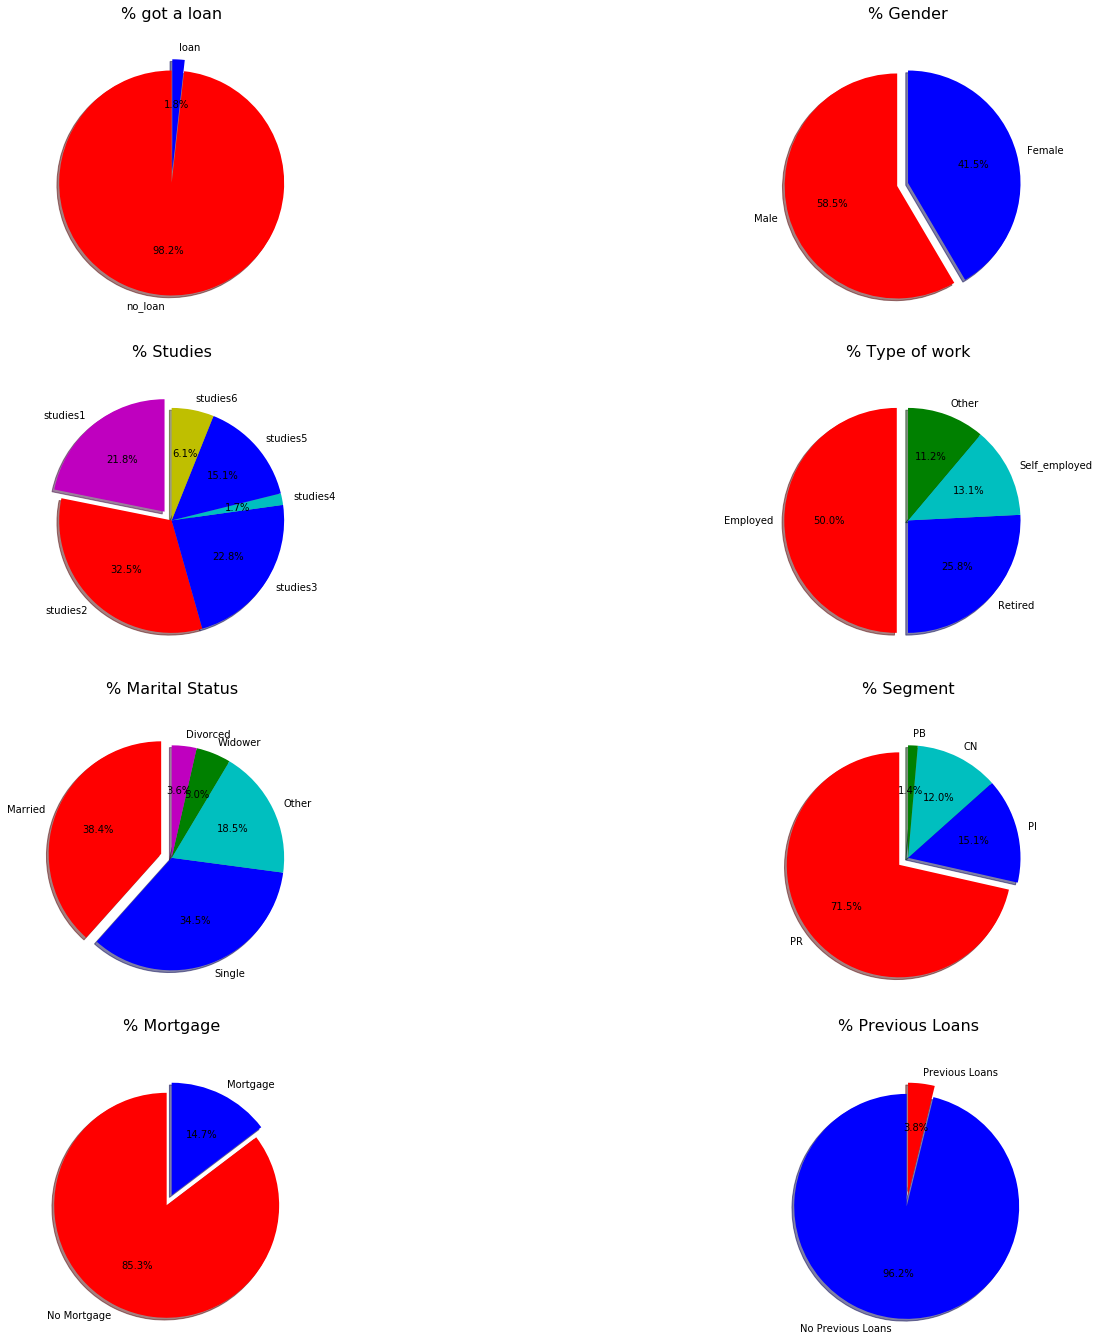

In [30]:
# 8. Plot all the categorical features without differenciating loan or not loan

#slices-count each score(pie plot)

df = categorical_file_final_graph.copy() 
compare_col_graph= 'got_loan'
plt.figure(figsize=(10,30))
'''values taking from the previous encoding results'''
val1,val2 = 0,1

''' count number clients with or without loan'''
no_loan = df.loc[df[compare_col_graph] == val1].count()
loan = df.loc[df[compare_col_graph] == val2].count()

plt.subplot(5, 2, 1)
title1 = '% got a loan\n'
plt.title(title1,fontsize = 16)
slices = [pd.Series(no_loan)[0],pd.Series(loan)[0]]
activities = ['no_loan','loan']
cols = ['r', 'b']
# plot

'''startangle :Angle from where the pie partitions start. In this case perpendicular to the tittle'''
'''shade: shade on the graph'''
'''explode: outstand some of the pie parts'''
'''autopct:include the percentage'''
plt.pie (slices,
        labels = activities,
        colors = cols,
        startangle = 90,  
        shadow = True,     
        explode = (0,0.1),  
        autopct = '%1.1f%%')  

# pie with gender

plt.subplot(5, 2, 2)
plt.subplots_adjust(right = 2)
title2 = '% Gender\n'
val1,val2 = 1,0

plt.title(title2,fontsize = 16)
compare_col_graph_gender= 'gender_dum'

male = df.loc[df[compare_col_graph_gender] == val1].count()
female = df.loc[df[compare_col_graph_gender] == val2].count() 

slices_gender = [pd.Series(male)[0],pd.Series(female)[0]]
activities_gender = ['Male','Female']
cols_gender = ['r','b']


plt.pie (slices_gender,
        labels = activities_gender,
        colors = cols_gender,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0),
        autopct = '%1.1f%%')

# pie with studies

plt.subplot(5, 2, 3)
# plt.subplots_adjust(right = 2.2)
title3 = '% Studies\n'
val1,val2,val3,val4,val5,val6 = 0,1,2,3,4,5
plt.title(title3,fontsize = 16)
compare_col_graph_work= 'studies_dum'

studies1 = df.loc[df[compare_col_graph_work] == val1].count()
studies2 = df.loc[df[compare_col_graph_work] == val2].count() 
studies3 = df.loc[df[compare_col_graph_work] == val3].count()
studies4 = df.loc[df[compare_col_graph_work] == val4].count() 
studies5 = df.loc[df[compare_col_graph_work] == val5].count() 
studies6 = df.loc[df[compare_col_graph_work] == val6].count()


slices_work = [pd.Series(studies1)[0],pd.Series(studies2)[0],pd.Series(studies3)[0],pd.Series(studies4)[0]
               ,pd.Series(studies5)[0],pd.Series(studies6)[0]]
activities_work = ['studies1','studies2','studies3','studies4','studies5','studies6']
cols_work = ['m', 'r', 'b','c','b','y']



plt.pie (slices_work,
        labels = activities_work,
        colors = cols_work,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0,0,0,0,0), 
        autopct = '%1.1f%%')  

# pie with type of work

plt.subplot(5, 2, 4)
plt.subplots_adjust(right = 2.2)
title4 = '% Type of work\n'
val1,val2,val3,val4 = 0,1,3,2
plt.title(title4,fontsize = 16)
compare_col_graph_work= 'work_type_dum'

employed = df.loc[df[compare_col_graph_work] == val1].count()
retired = df.loc[df[compare_col_graph_work] == val2].count() 
self_employed = df.loc[df[compare_col_graph_work] == val3].count()
other = df.loc[df[compare_col_graph_work] == val4].count() 

slices_work = [pd.Series(employed)[0],pd.Series(retired)[0],pd.Series(self_employed)[0],pd.Series(other)[0]]
activities_work = ['Employed','Retired','Self_employed','Other']
cols_work = ['r', 'b', 'c','g']



plt.pie (slices_work,
        labels = activities_work,
        colors = cols_work,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0,0,0), 
        autopct = '%1.1f%%')  

# pie with marital status

plt.subplot(5, 2, 5)
# plt.subplots_adjust(right = 2.2)
title5 = '% Marital Status\n'
val1,val2,val3,val4,val5 = 0,3,2,4,1
plt.title(title5,fontsize = 16)
compare_col_graph_work= 'marital_status_dum'

married = df.loc[df[compare_col_graph_work] == val1].count()
single = df.loc[df[compare_col_graph_work] == val2].count() 
other= df.loc[df[compare_col_graph_work] == val3].count()
widower = df.loc[df[compare_col_graph_work] == val4].count() 
divorced = df.loc[df[compare_col_graph_work] == val5].count()

slices_work = [pd.Series(married)[0],pd.Series(single)[0],pd.Series(other)[0],pd.Series(widower)[0],pd.Series(divorced)[0]]
activities_work = ['Married','Single','Other','Widower','Divorced']
cols_work = ['r', 'b', 'c','g','m']



plt.pie (slices_work,
        labels = activities_work,
        colors = cols_work,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0,0,0,0), 
        autopct = '%1.1f%%') 


# pie with segment

plt.subplot(5, 2, 6)
# plt.subplots_adjust(right = 2.2)
title6 = '% Segment\n'
val1,val2,val3,val4 = 3,2,0,1
plt.title(title6,fontsize = 16)
compare_col_graph_work= 'codseg_dum'

PR = df.loc[df[compare_col_graph_work] == val1].count()
PI = df.loc[df[compare_col_graph_work] == val2].count() 
CN = df.loc[df[compare_col_graph_work] == val3].count()
PB = df.loc[df[compare_col_graph_work] == val4].count() 

slices_work = [pd.Series(PR)[0],pd.Series(PI)[0],pd.Series(CN)[0],pd.Series(PB)[0]]
activities_work = ['PR','PI','CN','PB']
cols_work = ['r', 'b', 'c','g']

plt.pie (slices_work,
        labels = activities_work,
        colors = cols_work,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0,0,0), 
        autopct = '%1.1f%%') 

# pie with mortgage

plt.subplot(5, 2, 7)
plt.subplots_adjust(right = 2)
title7 = '% Mortgage\n'
val1,val2 = 0,1

plt.title(title7,fontsize = 16)
compare_col_graph_mortg= 'mortgage_dum'

no_mortg = df.loc[df[compare_col_graph_mortg] == val1].count()
mortg = df.loc[df[compare_col_graph_mortg] == val2].count() 

slices_mortg = [pd.Series(no_mortg)[0],pd.Series(mortg)[0]]
activities_mortg = ['No Mortgage','Mortgage']
cols_mortg = ['r','b']


plt.pie (slices_mortg,
        labels = activities_mortg,
        colors = cols_mortg,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0),
        autopct = '%1.1f%%')

# pie with previous loans

plt.subplot(5, 2, 8)
plt.subplots_adjust(right = 2)
title8 = '% Previous Loans\n'
val1,val2 = 0,1

plt.title(title8,fontsize = 16)
compare_col_graph_prevloans= 'previous_loans_dum'
no_prev_loans = df.loc[df[compare_col_graph_prevloans] == val1].count()
prev_loans = df.loc[df[compare_col_graph_prevloans] == val2].count() 

slices_prevloans = [pd.Series(no_prev_loans)[0],pd.Series(prev_loans)[0]]
activities_prevloans = ['No Previous Loans','Previous Loans']
cols_prevloans = ['b','r']


plt.pie (slices_prevloans,
        labels = activities_prevloans,
        colors = cols_prevloans,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0),
        autopct = '%1.1f%%')


plt.show()

### 2.1.1 Categorical features visualization (bar plot) <a class="anchor" id="2.1.1-bullet"></a>
[table of contents](#index-bullet)

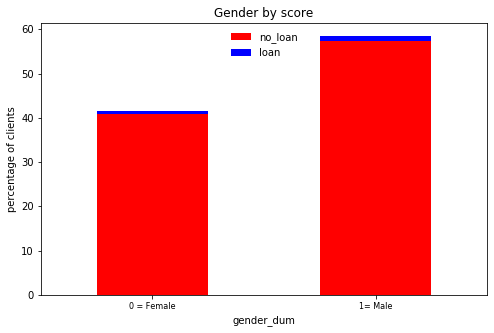

got_loan        0     1
gender_dum             
female      40.84  0.68
male        57.39  1.08


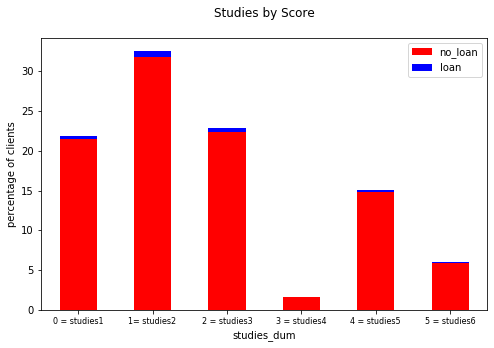

got_loan         0     1
studies_dum             
studies1     21.52  0.31
studies2     31.85  0.70
studies3     22.41  0.40
studies4      1.65  0.02
studies5     14.84  0.22
studies6      5.95  0.11


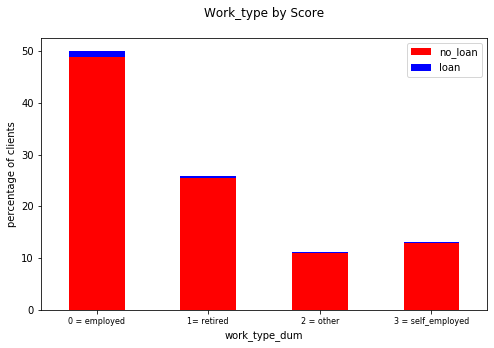

got_loan           0     1
work_type_dum             
employed       48.89  1.11
retired        25.50  0.29
other          11.01  0.14
self_employed  12.82  0.23


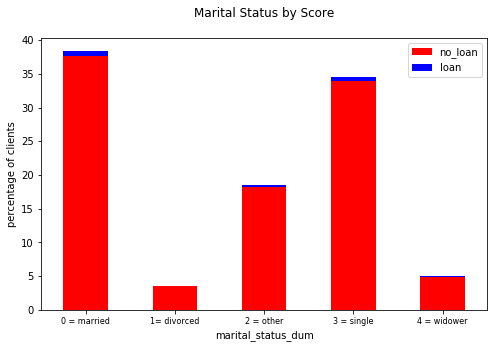

got_loan                0     1
marital_status_dum             
married             37.73  0.66
divorced             3.51  0.06
other               18.20  0.34
single              33.89  0.61
widower              4.91  0.09


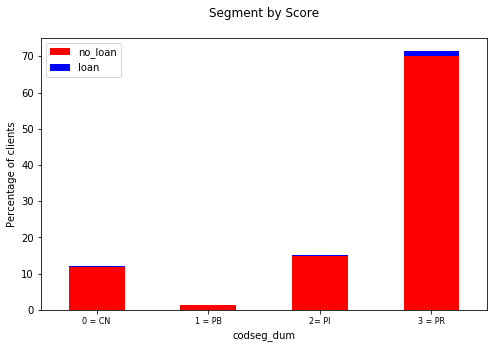

got_loan        0     1
codseg_dum             
CN          11.77  0.24
PB           1.38  0.01
PI          14.99  0.15
PR          70.09  1.37


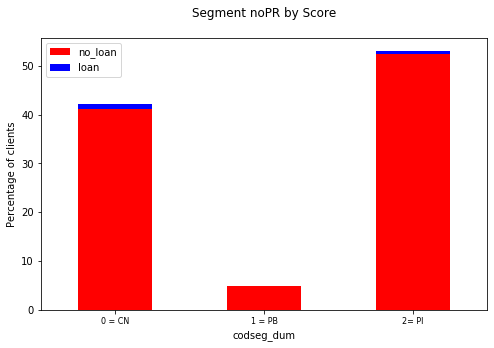

got_loan        0     1
codseg_dum             
CN          41.26  0.84
PB           4.83  0.04
PI          52.53  0.51


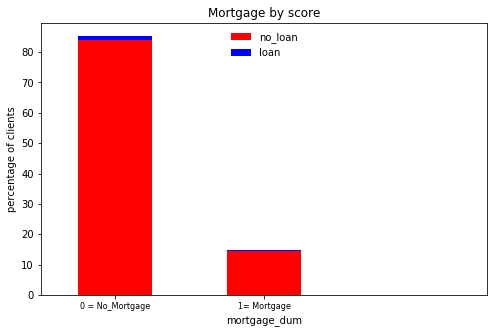

got_loan          0     1
mortgage_dum             
mortgage_no   83.86  1.45
mortgage_yes  14.35  0.32
2              0.03  0.00


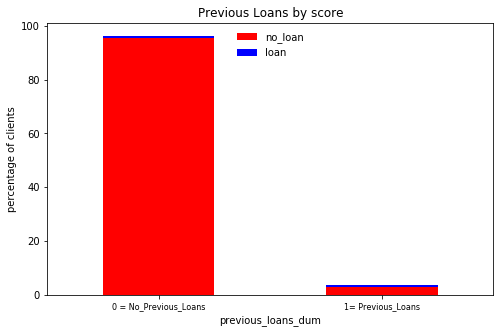

got_loan                0     1
previous_loans_dum             
previous_loans_no   95.27  0.91
previous_loans_yes   2.96  0.86


In [31]:
#  9. Same analysis done previously but differenciating with or without loan(bar plot)

# stacked graph
'''same values used'''
values_scored =  [0,1]

colors = ["r", "b"]

# gender

''' create df only with the columns i need'''
df_ge = df[['got_loan','gender_dum']]

''' group creating a new column counting the clients for each group'''
df_group_ge = df_ge.groupby(['got_loan','gender_dum'])['got_loan'].count().reset_index(name="count")
''' create percentage for each group category'''
percentage_dist_ge = 100 * df_group_ge[['count']].divide(df_group_ge[['count']].sum(), axis = 1)
''' drop the count so i keep only the percentage column'''
df_group_ge.drop(columns= 'count', inplace = True)
'''add the percentage column '''
gender_df= pd.concat([df_group_ge,percentage_dist_ge],axis = 1)

gender_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
'''transpose the df to create the stacked bar plot '''
pivot_df_ge = gender_df.pivot(index='gender_dum', columns='got_loan', values='percentage')

pivot_df_ge.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))

''' transpose to show the detail table underneath and rename the lengend '''
rename_df_ge = pivot_df_ge.rename(columns={"0": "No-Loan", "1": "Loan"},index={0 :"female",1: "male"})
'''round the values in the table under bar plot'''
rename_df_ge_r =rename_df_ge.round(2)

plt.title('Gender by score')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = Female','1= Male'],size = 8,rotation=0)
'''rename the legend and plot it in the center'''
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_ge_r)

# studies

df_st = df[['got_loan','studies_dum']]
df_group_st = df_st.groupby(['got_loan','studies_dum'])['got_loan'].count().reset_index(name="count")

percentage_dist_st = 100 * df_group_st[['count']].divide(df_group_st[['count']].sum(), axis = 1)
df_group_st.drop(columns= 'count', inplace = True)

st_df= pd.concat([df_group_st,percentage_dist_st],axis = 1)

st_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_st =st_df.pivot(index='studies_dum', columns='got_loan', values='percentage')

pivot_df_st.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_st = pivot_df_st.rename(columns={"0": "No-Loan", "1": "Loan"},
                                  index={0 :"studies1", 1: "studies2",2:"studies3",3:"studies4",4:"studies5",5:"studies6"})
                                                
rename_df_st_r =rename_df_st.round(2)

plt.title('Studies by Score\n')
plt.ylabel('percentage of clients')
plt.xticks (range(6), ['0 = studies1','1= studies2', '2 = studies3', '3 = studies4','4 = studies5','5 = studies6'],rotation=0,size = 8)
plt.legend(labels = activities)
plt.show()
print(rename_df_st_r)


# type of work

df_wt = df[['got_loan','work_type_dum']]
df_group_wt = df_wt.groupby(['got_loan','work_type_dum'])['got_loan'].count().reset_index(name="count")

percentage_dist_tiptrab = 100 * df_group_wt[['count']].divide(df_group_wt[['count']].sum(), axis = 1)
df_group_wt.drop(columns= 'count', inplace = True)

tiptraba_df= pd.concat([df_group_wt,percentage_dist_tiptrab],axis = 1)

tiptraba_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_wt = tiptraba_df.pivot(index='work_type_dum', columns='got_loan', values='percentage')

pivot_df_wt.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_wt = pivot_df_wt.rename(columns={"0": "No-Loan", "1": "Loan"},
                                  index={0 :"employed", 1: "retired",2:"other",3:"self_employed"})
                                                
rename_df_wt_r =rename_df_wt.round(2)

plt.title('Work_type by Score\n')
plt.ylabel('percentage of clients')
plt.xticks (range(4), ['0 = employed','1= retired', '2 = other', '3 = self_employed'],rotation=0,size = 8)
plt.legend(labels = activities)
plt.show()
print(rename_df_wt_r)

# marital status

df_ms = df[['got_loan','marital_status_dum']]
df_group_ms = df_ms.groupby(['got_loan','marital_status_dum'])['got_loan'].count().reset_index(name="count")

percentage_dist_ms = 100 * df_group_ms[['count']].divide(df_group_ms[['count']].sum(), axis = 1)
df_group_ms.drop(columns= 'count', inplace = True)

ms_df= pd.concat([df_group_ms,percentage_dist_ms],axis = 1)

ms_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_ms = ms_df.pivot(index='marital_status_dum', columns='got_loan', values='percentage')

pivot_df_ms.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_ms = pivot_df_ms.rename(columns={"0": "No-Loan", "1": "Loan"},
                                  index={0 :"married", 1: "divorced",2:"other",3:"single",4:"widower"})
                                                
rename_df_ms_r =rename_df_ms.round(2)

plt.title('Marital Status by Score\n')
plt.ylabel('percentage of clients')
plt.xticks (range(5), ['0 = married','1= divorced', '2 = other', '3 = single', '4 = widower'],rotation=0,size = 8)
plt.legend(labels = activities)
plt.show()
print(rename_df_ms_r)

# codseg_dum

df_seg = df[['got_loan','codseg_dum']]
df_group_seg = df_seg.groupby(['got_loan','codseg_dum'])['got_loan'].count().reset_index(name="count")
percentage_dist_seg = 100 * df_group_seg[['count']].divide(df_group_seg[['count']].sum(), axis = 1)
df_group_seg.drop(columns= 'count', inplace = True)
codseg_df= pd.concat([df_group_seg,percentage_dist_seg],axis = 1)

codseg_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_seg = codseg_df.pivot(index='codseg_dum', columns='got_loan', values='percentage')
pivot_df_seg.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_seg = pivot_df_seg.rename(columns={"0": "No-Loan", "1": "Loan"},
                                    index={0: "CN", 1: "PB", 2: "PI",3 : "PR"})
rename_df_seg_r =rename_df_seg.round(2)
plt.title('Segment by Score\n')
plt.ylabel('Percentage of clients')
plt.xticks (range(4), ['0 = CN','1 = PB','2= PI','3 = PR'],size = 8,rotation = 0)
plt.legend(labels = activities)
plt.show()
print(rename_df_seg_r)



# Segmento sin PR

df_seg_npr = df_seg.loc[df_seg['codseg_dum'] != 3]
df_group_seg_npr = df_seg_npr.groupby(['got_loan','codseg_dum'])['got_loan'].count().reset_index(name="count")
percentage_dist_seg_npr = 100 * df_group_seg_npr[['count']].divide(df_group_seg_npr[['count']].sum(), axis = 1)
df_group_seg_npr.drop(columns= 'count', inplace = True)
codseg_nopr_df= pd.concat([df_group_seg_npr,percentage_dist_seg_npr],axis = 1)

codseg_nopr_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_seg_npr = codseg_nopr_df.pivot(index='codseg_dum', columns='got_loan', values='percentage')
pivot_df_seg_npr.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_seg_npr = pivot_df_seg_npr.rename(columns={"0": "No-Loan", "1": "Loan"},
                                            index={0: "CN", 1: "PB", 2: "PI"})
rename_df_seg_npr_r =rename_df_seg_npr.round(2)

plt.title('Segment noPR by Score\n')
plt.ylabel('Percentage of clients')
plt.xticks (range(3), ['0 = CN','1 = PB','2= PI'],size = 8,rotation = 0)
plt.legend(labels = activities)
plt.show()
print(rename_df_seg_npr_r )


#mortgage

df_mor = df[['got_loan','mortgage_dum']]
df_group_mor = df_mor.groupby(['got_loan','mortgage_dum'])['got_loan'].count().reset_index(name="count")

percentage_dist_mor = 100 * df_group_mor[['count']].divide(df_group_mor[['count']].sum(), axis = 1)
df_group_mor.drop(columns= 'count', inplace = True)

mortgage_df= pd.concat([df_group_mor,percentage_dist_mor],axis = 1)

mortgage_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_mor = mortgage_df.pivot(index='mortgage_dum', columns='got_loan', values='percentage')

pivot_df_mor.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_mor = pivot_df_mor.rename(columns={"0": "No-Loan", "1": "Loan"},
                                    index={0 :"mortgage_no",1: "mortgage_yes"})
rename_df_mor_r =rename_df_mor.round(2)
plt.title('Mortgage by score')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = No_Mortgage','1= Mortgage'],size = 8,rotation=0)
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_mor_r)

#previous loans

df_prevloans = df[['got_loan','previous_loans_dum']]
df_group_prevloans = df_prevloans.groupby(['got_loan','previous_loans_dum'])['got_loan'].count().reset_index(name="count")

percentage_dist_prevloans = 100 * df_group_prevloans[['count']].divide(df_group_prevloans[['count']].sum(), axis = 1)
df_group_prevloans.drop(columns= 'count', inplace = True)

prevloans_df= pd.concat([df_group_prevloans,percentage_dist_prevloans],axis = 1)

prevloans_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_prevloans = prevloans_df.pivot(index='previous_loans_dum', columns='got_loan', values='percentage')

pivot_df_prevloans.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_prevloans = pivot_df_prevloans.rename(columns={"0": "No-Loan", "1": "Loan"},
                                    index={0 :"previous_loans_no",1: "previous_loans_yes"})
rename_df_prevloans_r =rename_df_prevloans.round(2)
plt.title('Previous Loans by score')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = No_Previous_Loans','1= Previous_Loans'],size = 8,rotation=0)
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_prevloans_r)


### 2.1.2 Categorical features visualization (bar plot-base 100) <a class="anchor" id="2.1.2-bullet"></a>
[table of contents](#index-bullet)

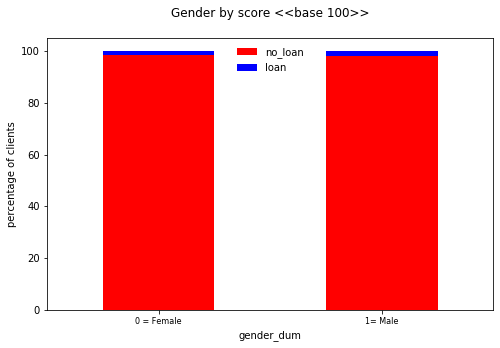

got_loan        0     1
gender_dum             
female      98.35  1.65
male        98.14  1.86


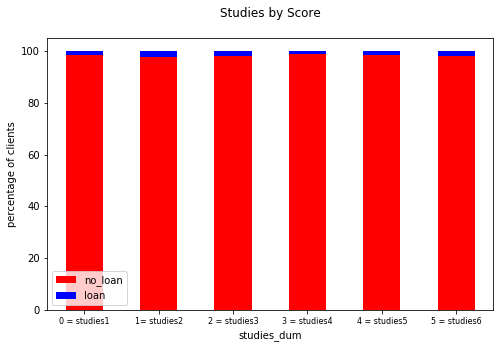

got_loan         0     1
studies_dum             
studies1     98.57  1.43
studies2     97.84  2.16
studies3     98.23  1.77
studies4     99.03  0.97
studies5     98.53  1.47
studies6     98.16  1.84


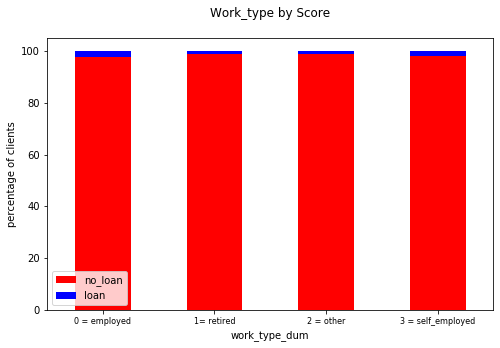

got_loan           0     1
work_type_dum             
employed       97.79  2.21
retired        98.87  1.13
other          98.75  1.25
self_employed  98.21  1.79


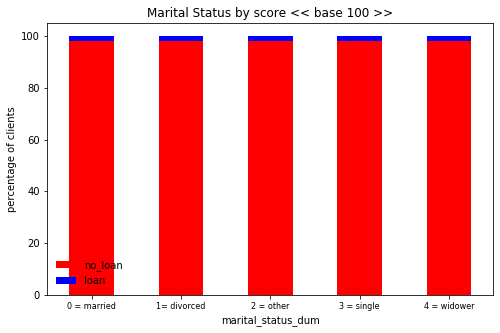

got_loan                0     1
marital_status_dum             
married             98.27  1.73
divorced            98.18  1.82
other               98.15  1.85
single              98.23  1.77
widower             98.27  1.73


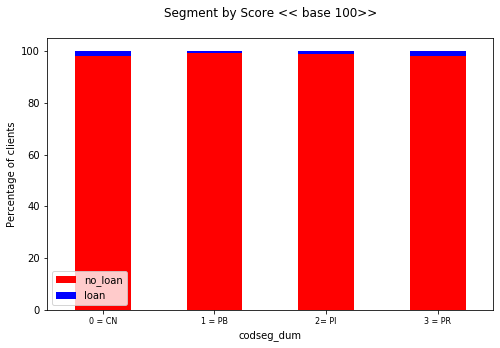

got_loan        0     1
codseg_dum             
CN          98.02  1.98
PB          99.20  0.80
PI          99.04  0.96
PR          98.08  1.92


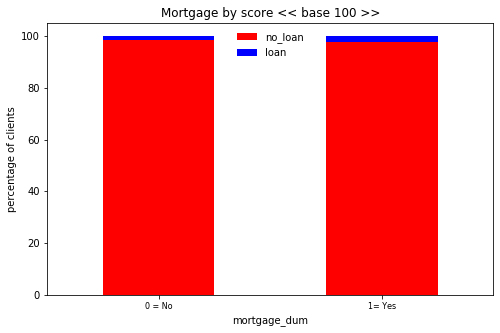

got_loan          0     1
mortgage_dum             
mortgage_no   98.30  1.70
mortgage_yes  97.81  2.19


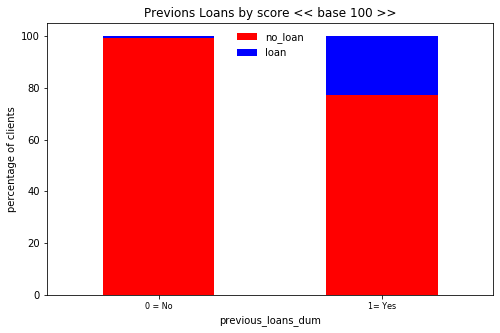

got_loan                0      1
previous_loans_dum              
Previous_Loans_no   99.06   0.94
Previous_Loans_yes  77.41  22.59


In [32]:
# 10. study to understand under which conditions the model gives a higher probability 
# of getting a loan of each group

col1= 'got_loan'
# gender base 100
''' create df only with the columns i need'''
df_gender = df[[col1,'gender_dum']]
''' group creating a new column cunting the clients for each group'''
df_group_gender = df_gender.groupby([col1,'gender_dum'])[col1].count().reset_index(name="count")
''' create percentage for each group category. In this case female and male'''
df_group_gender_0 =df_group_gender[df_group_gender['gender_dum'] == 0]
percentage_dist_gender_0 = 100 * df_group_gender_0[['count']].divide(df_group_gender_0[['count']].sum(), axis = 1)
''' drop the count so i keep only the percentage column'''
df_group_gender_0.drop(columns= 'count', inplace = True)
'''add the percentage column '''
gender_d_0= pd.concat([df_group_gender_0,percentage_dist_gender_0],axis = 1)


df_group_gender_1 =df_group_gender[df_group_gender['gender_dum'] == 1]
percentage_dist_gender_1 = 100 * df_group_gender_1[['count']].divide(df_group_gender_1[['count']].sum(), axis = 1)
df_group_gender_1.drop(columns= 'count', inplace = True)
gender_d_1= pd.concat([df_group_gender_1,percentage_dist_gender_1],axis = 1)


gender_df_base100= pd.concat([gender_d_0,gender_d_1],axis = 0)
gender_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
'''transpose the df to create the stacked bar plot '''
pivot_df_ge_base100 = gender_df_base100.pivot(index='gender_dum', columns=col1, values='percentage')

pivot_df_ge_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
''' transpose to show the detail table underneath and rename the lengend '''
rename_df_ge_base100 = pivot_df_ge_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                  index={0 :"female",1: "male"})
'''round the values in the table underneath bar plot'''
rename_df_ge_r_base100 =rename_df_ge_base100.round(2)
plt.title('Gender by score <<base 100>>\n')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = Female','1= Male'],size = 8,rotation=0)
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_ge_r_base100)

# Studies base 100

df_st = df[[col1,'studies_dum']]
df_group_st = df_st.groupby([col1,'studies_dum'])[col1].count().reset_index(name="count")

df_group_st_0 =df_group_st[df_group_st['studies_dum'] == 0]
percentage_dist_st_0 = 100 * df_group_st_0[['count']].divide(df_group_st_0[['count']].sum(), axis = 1)
df_group_st_0.drop(columns= 'count', inplace = True)
st_d_0= pd.concat([df_group_st_0,percentage_dist_st_0],axis = 1)
    
df_group_st_1 =df_group_st[df_group_st['studies_dum'] == 1]
percentage_dist_st_1 = 100 * df_group_st_1[['count']].divide(df_group_st_1[['count']].sum(), axis = 1)
df_group_st_1.drop(columns= 'count', inplace = True)
st_d_1= pd.concat([df_group_st_1,percentage_dist_st_1],axis = 1)

df_group_st_2 =df_group_st[df_group_st['studies_dum'] == 2]
percentage_dist_st_2 = 100 * df_group_st_2[['count']].divide(df_group_st_2[['count']].sum(), axis = 1)
df_group_st_2.drop(columns= 'count', inplace = True)
st_d_2= pd.concat([df_group_st_2,percentage_dist_st_2],axis = 1)

df_group_st_3=df_group_st[df_group_st['studies_dum'] == 3]
percentage_dist_st_3 = 100 * df_group_st_3[['count']].divide(df_group_st_3[['count']].sum(), axis = 1)
df_group_st_3.drop(columns= 'count', inplace = True)
st_d_3= pd.concat([df_group_st_3,percentage_dist_st_3],axis = 1)

df_group_st_4=df_group_st[df_group_st['studies_dum'] == 4]
percentage_dist_st_4 = 100 * df_group_st_4[['count']].divide(df_group_st_4[['count']].sum(), axis = 1)
df_group_st_4.drop(columns= 'count', inplace = True)
st_d_4= pd.concat([df_group_st_4,percentage_dist_st_4],axis = 1)

df_group_st_5=df_group_st[df_group_st['studies_dum'] == 5]
percentage_dist_st_5 = 100 * df_group_st_5[['count']].divide(df_group_st_5[['count']].sum(), axis = 1)
df_group_st_5.drop(columns= 'count', inplace = True)
st_d_5= pd.concat([df_group_st_5,percentage_dist_st_5],axis = 1)

st_df_base100= pd.concat([st_d_0,st_d_1,st_d_2,st_d_3,st_d_4,st_d_5],axis = 0)

st_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_st_base100 = st_df_base100.pivot(index='studies_dum', columns=col1, values='percentage')

pivot_df_st_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_st_base100 = pivot_df_st_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                  index={0 :"studies1",1: "studies2",2:"studies3",3:"studies4",4:"studies5",5:"studies6"})
rename_df_st_r_base100 =rename_df_st_base100.round(2)
plt.title('Studies by Score\n')
plt.ylabel('percentage of clients')
plt.xticks (range(6), ['0 = studies1','1= studies2', '2 = studies3', '3 = studies4', '4 = studies5', '5 = studies6'],rotation=0,size = 8)
plt.legend(labels = activities)
plt.show()
print(rename_df_st_r_base100)

# type of work base 100

df_wt = df[[col1,'work_type_dum']]
df_group_wt = df_wt.groupby([col1,'work_type_dum'])[col1].count().reset_index(name="count")

df_group_wt_0 =df_group_wt[df_group_wt['work_type_dum'] == 0]
percentage_dist_wt_0 = 100 * df_group_wt_0[['count']].divide(df_group_wt_0[['count']].sum(), axis = 1)
df_group_wt_0.drop(columns= 'count', inplace = True)
wt_d_0= pd.concat([df_group_wt_0,percentage_dist_wt_0],axis = 1)
    
df_group_wt_1 =df_group_wt[df_group_wt['work_type_dum'] == 1]
percentage_dist_wt_1 = 100 * df_group_wt_1[['count']].divide(df_group_wt_1[['count']].sum(), axis = 1)
df_group_wt_1.drop(columns= 'count', inplace = True)
wt_d_1= pd.concat([df_group_wt_1,percentage_dist_wt_1],axis = 1)

df_group_wt_2 =df_group_wt[df_group_wt['work_type_dum'] == 2]
percentage_dist_wt_2 = 100 * df_group_wt_2[['count']].divide(df_group_wt_2[['count']].sum(), axis = 1)
df_group_wt_2.drop(columns= 'count', inplace = True)
wt_d_2= pd.concat([df_group_wt_2,percentage_dist_wt_2],axis = 1)

df_group_wt_3=df_group_wt[df_group_wt['work_type_dum'] == 3]
percentage_dist_wt_3 = 100 * df_group_wt_3[['count']].divide(df_group_wt_3[['count']].sum(), axis = 1)
df_group_wt_3.drop(columns= 'count', inplace = True)
wt_d_3= pd.concat([df_group_wt_3,percentage_dist_wt_3],axis = 1)

wt_df_base100= pd.concat([wt_d_0,wt_d_1,wt_d_2,wt_d_3],axis = 0)

wt_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_wt_base100 = wt_df_base100.pivot(index='work_type_dum', columns=col1, values='percentage')

pivot_df_wt_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_wt_base100 = pivot_df_wt_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                  index={0 :"employed",1: "retired",2:"other",3:"self_employed"})
rename_df_wt_r_base100 =rename_df_wt_base100.round(2)
plt.title('Work_type by Score\n')
plt.ylabel('percentage of clients')
plt.xticks (range(4), ['0 = employed','1= retired', '2 = other', '3 = self_employed'],rotation=0,size = 8)
plt.legend(labels = activities)
plt.show()
print(rename_df_wt_r_base100)

# marital status base 100

df_ms = df[[col1,'marital_status_dum']]
df_group_ms = df_ms.groupby([col1,'marital_status_dum'])[col1].count().reset_index(name="count")

df_group_ms_0 =df_group_ms[df_group_ms['marital_status_dum'] == 0]
percentage_dist_ms_0 = 100 * df_group_ms_0[['count']].divide(df_group_ms_0[['count']].sum(), axis = 1)
df_group_ms_0.drop(columns= 'count', inplace = True)
ms_d_0= pd.concat([df_group_ms_0,percentage_dist_ms_0],axis = 1)

df_group_ms_1 =df_group_ms[df_group_ms['marital_status_dum'] == 1]
percentage_dist_ms_1 = 100 * df_group_ms_1[['count']].divide(df_group_ms_1[['count']].sum(), axis = 1)
df_group_ms_1.drop(columns= 'count', inplace = True)
ms_d_1= pd.concat([df_group_ms_1,percentage_dist_ms_1],axis = 1)

df_group_ms_2 =df_group_ms[df_group_ms['marital_status_dum'] == 2]
percentage_dist_ms_2 = 100 * df_group_ms_2[['count']].divide(df_group_ms_2[['count']].sum(), axis = 1)
df_group_ms_2.drop(columns= 'count', inplace = True)
ms_d_2= pd.concat([df_group_ms_2,percentage_dist_ms_2],axis = 1)

df_group_ms_3 =df_group_ms[df_group_ms['marital_status_dum'] == 3]
percentage_dist_ms_3 = 100 * df_group_ms_3[['count']].divide(df_group_ms_3[['count']].sum(), axis = 1)
df_group_ms_3.drop(columns= 'count', inplace = True)
ms_d_3= pd.concat([df_group_ms_3,percentage_dist_ms_3],axis = 1)

df_group_ms_4 =df_group_ms[df_group_ms['marital_status_dum'] == 4]
percentage_dist_ms_4 = 100 * df_group_ms_4[['count']].divide(df_group_ms_4[['count']].sum(), axis = 1)
df_group_ms_4.drop(columns= 'count', inplace = True)
ms_d_4= pd.concat([df_group_ms_4,percentage_dist_ms_4],axis = 1)


ms_df_base100= pd.concat([ms_d_0,ms_d_1,ms_d_2,ms_d_3,ms_d_4],axis = 0)

ms_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_ms_base100 = ms_df_base100.pivot(index='marital_status_dum', columns='got_loan', values='percentage')

pivot_df_ms_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_ms_base100 = pivot_df_ms_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                    index={0 :"married", 1: "divorced",2:"other",3:"single",4:"widower"})
rename_df_ms_r_base100 =rename_df_ms_base100.round(2)
plt.title('Marital Status by score << base 100 >>')
plt.ylabel('percentage of clients')
plt.xticks (range(5), ['0 = married','1= divorced', '2 = other', '3 = single', '4 = widower'],size = 8,rotation=0)
plt.legend(labels = activities, frameon=False)
plt.show()
print(rename_df_ms_r_base100)

# codseg_dum base 100 


df_seg = df[[col1,'codseg_dum']]
df_group_seg = df_seg.groupby([col1,'codseg_dum'])[col1].count().reset_index(name="count")

df_group_seg_0 =df_group_seg[df_group_seg['codseg_dum'] == 0]
percentage_dist_seg_0 = 100 * df_group_seg_0[['count']].divide(df_group_seg_0[['count']].sum(), axis = 1)
df_group_seg_0.drop(columns= 'count', inplace = True)
seg_d_0= pd.concat([df_group_seg_0,percentage_dist_seg_0],axis = 1)
    
df_group_seg_1 =df_group_seg[df_group_seg['codseg_dum'] == 1]
percentage_dist_seg_1 = 100 * df_group_seg_1[['count']].divide(df_group_seg_1[['count']].sum(), axis = 1)
df_group_seg_1.drop(columns= 'count', inplace = True)
seg_d_1= pd.concat([df_group_seg_1,percentage_dist_seg_1],axis = 1)

df_group_seg_2 =df_group_seg[df_group_seg['codseg_dum'] == 2]
percentage_dist_seg_2 = 100 * df_group_seg_2[['count']].divide(df_group_seg_2[['count']].sum(), axis = 1)
df_group_seg_2.drop(columns= 'count', inplace = True)
seg_d_2= pd.concat([df_group_seg_2,percentage_dist_seg_2],axis = 1)

df_group_seg_3=df_group_seg[df_group_seg['codseg_dum'] == 3]
percentage_dist_seg_3 = 100 * df_group_seg_3[['count']].divide(df_group_seg_3[['count']].sum(), axis = 1)
df_group_seg_3.drop(columns= 'count', inplace = True)
seg_d_3= pd.concat([df_group_seg_3,percentage_dist_seg_3],axis = 1)

seg_df_base100= pd.concat([seg_d_0,seg_d_1,seg_d_2,seg_d_3],axis = 0)

seg_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_seg_base100 = seg_df_base100.pivot(index='codseg_dum', columns=col1, values='percentage')

pivot_df_seg_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_seg_base100 = pivot_df_seg_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                    index={0 :"CN",1: "PB",2:"PI",3:"PR"})
rename_df_seg_r_base100 =rename_df_seg_base100.round(2)
plt.title('Segment by Score << base 100>>\n')
plt.ylabel('Percentage of clients')
plt.xticks (range(4), ['0 = CN','1 = PB','2= PI','3 = PR'],size = 8,rotation = 0)
plt.legend(labels = activities)
plt.show()
print(rename_df_seg_r_base100)



# mortgage base 100

df_mor = df[[col1,'mortgage_dum']]
df_group_mor = df_mor.groupby([col1,'mortgage_dum'])[col1].count().reset_index(name="count")

df_group_mor_0 =df_group_mor[df_group_mor['mortgage_dum'] == 0]
percentage_dist_mor_0 = 100 * df_group_mor_0[['count']].divide(df_group_mor_0[['count']].sum(), axis = 1)
df_group_mor_0.drop(columns= 'count', inplace = True)
mortgage_d_0= pd.concat([df_group_mor_0,percentage_dist_mor_0],axis = 1)

df_group_mor_1 =df_group_mor[df_group_mor['mortgage_dum'] == 1]
percentage_dist_mor_1 = 100 * df_group_mor_1[['count']].divide(df_group_mor_1[['count']].sum(), axis = 1)
df_group_mor_1.drop(columns= 'count', inplace = True)
mortgage_d_1= pd.concat([df_group_mor_1,percentage_dist_mor_1],axis = 1)

mortgage_df_base100= pd.concat([mortgage_d_0,mortgage_d_1],axis = 0)

mortgage_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_mor_base100 = mortgage_df_base100.pivot(index='mortgage_dum', columns='got_loan', values='percentage')

pivot_df_mor_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_mor_base100 = pivot_df_mor_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                    index={0 :"mortgage_no",1: "mortgage_yes"})
rename_df_mor_r_base100 =rename_df_mor_base100.round(2)
plt.title('Mortgage by score << base 100 >>')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = No','1= Yes'],size = 8,rotation=0)
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_mor_r_base100)


# Previous Loans base 100

df_prevloans = df[[col1,'previous_loans_dum']]
df_group_prevloans = df_prevloans.groupby([col1,'previous_loans_dum'])[col1].count().reset_index(name="count")

df_group_prevloans_0 =df_group_prevloans[df_group_prevloans['previous_loans_dum'] == 0]
percentage_dist_prevloans_0 = 100 * df_group_prevloans_0[['count']].divide(df_group_prevloans_0[['count']].sum(), 
                                                                           axis = 1)
df_group_prevloans_0.drop(columns= 'count', inplace = True)
prevloans_d_0= pd.concat([df_group_prevloans_0,percentage_dist_prevloans_0],axis = 1)

df_group_prevloans_1 =df_group_prevloans[df_group_prevloans['previous_loans_dum'] == 1]
percentage_dist_prevloans_1 = 100 * df_group_prevloans_1[['count']].divide(df_group_prevloans_1[['count']].sum(),
                                                                           axis = 1)
df_group_prevloans_1.drop(columns= 'count', inplace = True)
prevloans_d_1= pd.concat([df_group_prevloans_1,percentage_dist_prevloans_1],axis = 1)

prevloans_df_base100= pd.concat([prevloans_d_0,prevloans_d_1],axis = 0)

prevloans_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_prevloans_base100 = prevloans_df_base100.pivot(index='previous_loans_dum', columns='got_loan',
                                                        values='percentage')

pivot_df_prevloans_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_prevloans_base100 = pivot_df_prevloans_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                    index={0 :"Previous_Loans_no",1: "Previous_Loans_yes"})
rename_df_prevloans_r_base100 =rename_df_prevloans_base100.round(2)
plt.title('Previons Loans by score << base 100 >>')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = No','1= Yes'],size = 8,rotation=0)
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_prevloans_r_base100)



### 2.2 Numercial visualization <a class="anchor" id="2.2-bullet"></a>
[table of contents](#index-bullet)

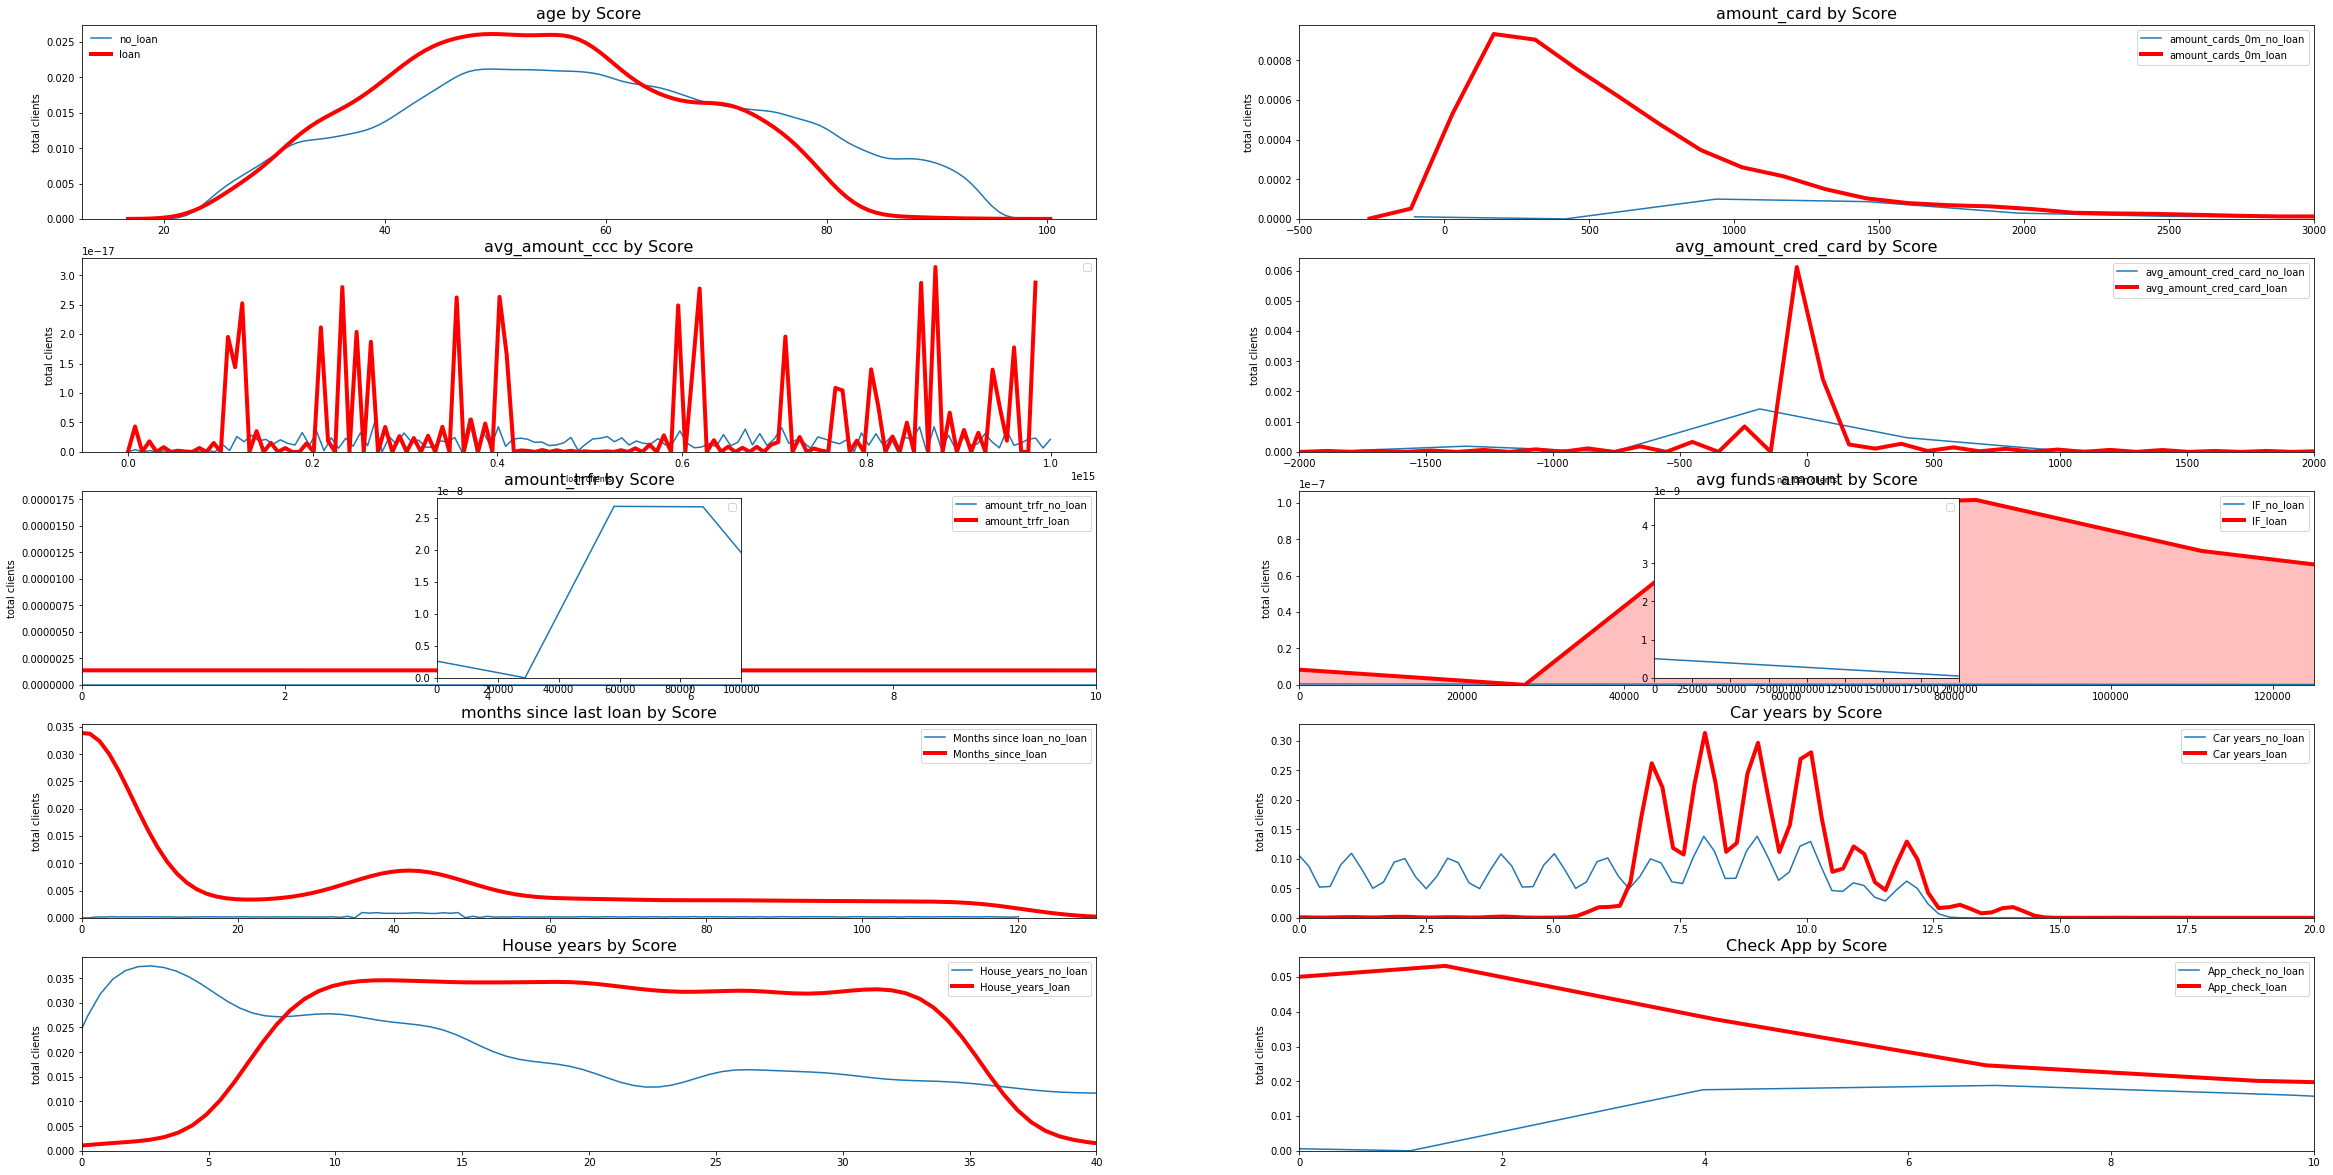

In [33]:
# 1. Using kdeplot from seaborn, plot numerical features which stand out as relevant
warnings.simplefilter('ignore')
'''as usual make a copy of the original dataset'''
graph_df = total_clients_mod.copy()

'''define the variable we are going to use for comparison'''
compare_col_graph = 'got_loan'
'''use the values of the dependent variable'''
val1,val2 = 0,1

''' count number clients with and without loan.Record in a variable'''
no_loan_graph = graph_df.loc[graph_df[compare_col_graph] == val1]
loan_graph = graph_df.loc[graph_df[compare_col_graph] == val2]

 # 2. Initialize the figure,size. Subplot also define the number of plots and its position
plt.figure(figsize=(40,25))
plt.subplot(6, 2, 1)

# 3. Plotting feature 'age'

'''set the title and size.
Define the feature to plot together with got loan values 0 and 1.Define different color and width for got_loan=1 
Set the frame and the legend positioning. 
Name the plot '''

plt.title('age by Score',fontsize = 16)
kdeplot(no_loan_graph.age,label='no_loan',)
kdeplot(loan_graph.age,label='loan',linewidth=4,c='r')
plt.legend(loc='upper left',frameon=False)
plt.ylabel('total clients')


# 4. Plotting feature 'amount_cards_0m'

plt.subplot(6, 2, 2)

plt.title('amount_card by Score',fontsize = 16)

kdeplot(no_loan_graph.amount_cards_0m,label= 'amount_cards_0m_no_loan')
kdeplot(loan_graph.amount_cards_0m,label='amount_cards_0m_loan',linewidth=4,c='r')

plt.xlim(-500, 3000)
plt.ylabel('total clients')


# 5. Plotting feature 'avg_amount_ccc'

ax = plt.subplot(6, 2, 3)

plt.title('avg_amount_ccc by Score',fontsize = 16)

kdeplot(no_loan_graph.aveg_amount_current_acc_0m,label= 'aveg_amount_current_acc_0m_no_loan')
kdeplot(loan_graph.aveg_amount_current_acc_0m,label='iaveg_amount_current_acc_0m_loan', linewidth=4,c='r')

plt.ylabel('total clients')
plt.legend('')


# 6. Plotting feature 'avg_amount_cred_card_0m'

plt.subplot(6, 2, 4)

plt.title('avg_amount_cred_card by Score',fontsize = 16)

kdeplot(no_loan_graph.aveg_amount_cred_card_0m,label='avg_amount_cred_card_no_loan')
kdeplot(loan_graph.aveg_amount_cred_card_0m,label='avg_amount_cred_card_loan',linewidth=4,c='r')
plt.xlim(-2000,2000)
plt.ylabel('total clients')

# 7. Plotting feature 'amount_trfr_0m'

ax = plt.subplot(6, 2, 5)

plt.title('amount_trfr by Score',fontsize = 16)

kdeplot(no_loan_graph.amount_trfr_0m,label='amount_trfr_no_loan')
kdeplot(loan_graph.amount_trfr_0m,label='amount_trfr_loan',linewidth=4,c='r')
plt.xlim(0,10)
plt.legend(loc = 'upper right')
plt.ylabel('total clients')

inset = inset_axes(ax, 
                   width="30%", # width = 30% of parent_bbox
                   height=2.5, # height : 1 inch
                   loc=10)

plt.title('loan clients\n',fontsize = 8)
kdeplot(no_loan_graph.amount_trfr_0m)
plt.xlim(0,100000)
plt.legend('')

# 8. Plotting feature 'aveg_amount_invest_funds_0m'

ax=plt.subplot(6, 2, 6)

plt.title('avg funds amount by Score',fontsize = 16)

kdeplot(no_loan_graph.aveg_amount_invest_funds_0m,label='IF_no_loan')
kdeplot(loan_graph.aveg_amount_invest_funds_0m,label='IF_loan',linewidth=4,shade = True,c='r')
plt.xlim(0,125000)
plt.ylabel('total clients')

inset = inset_axes(ax, 
                   width="30%", # width = 30% of parent_bbox
                   height=2.5, # height : 1 inch
                   loc=10)

plt.title('no_loan clients\n',fontsize = 8)
kdeplot(no_loan_graph.aveg_amount_invest_funds_0m)
plt.xlim(0,200000)
plt.legend('')

# 9. Plotting feature 'Months since loan'

plt.subplot(6, 2, 7)

plt.title('months since last loan by Score',fontsize = 16)

kdeplot(no_loan_graph.months_since_loan,label='Months since loan_no_loan')
kdeplot(loan_graph.months_since_loan,label='Months_since_loan',linewidth=4,c='r')
plt.xlim(0,130)
plt.ylabel('total clients')

# 10. Plotting feature 'Car Years'
plt.subplot(6, 2, 8)

plt.title('Car years by Score',fontsize = 16)

kdeplot(no_loan_graph.car_years,label='Car years_no_loan')
kdeplot(loan_graph.car_years,label='Car years_loan',linewidth=4,c='r')
plt.xlim(0,20)
plt.ylabel('total clients')

# 11. Plotting feature 'House years'
plt.subplot(6, 2, 9)

plt.title('House years by Score',fontsize = 16)

kdeplot(no_loan_graph.House_years,label='House_years_no_loan')
kdeplot(loan_graph.House_years,label='House_years_loan',linewidth=4,c='r')
plt.xlim(0,40)
plt.ylabel('total clients')

# 12. Plotting feature 'App check'

plt.subplot(6, 2, 10)

plt.title('Check App by Score',fontsize = 16)

kdeplot(no_loan_graph.app_par_0m,label='App_check_no_loan')
kdeplot(loan_graph.app_par_0m,label='App_check_loan',linewidth=4,c='r')
plt.xlim(0,10)
plt.ylabel('total clients')

plt.show()


### 2.3 Customers Geolocalization  <a class="anchor" id="2.3-bullet"></a>
[table of contents](#index-bullet)

In [34]:
# 1.  Clients geolocalitation by province total and the ones who got  a loan  

# 2. Need to install first folium :conda install -c conda-forge folium
'''download the map 4 files to local folder and read de shp file '''
polygon_path = os.path.abspath("Provincias.shp")
polygon_pc = gpd.read_file(polygon_path)
polygon_pc['COD_CCAA'] = polygon_pc['COD_CCAA'].astype(int)
''' select the column from my file,change column name to use as key with previous 
file polygon_pc and group the clients by postal code'''

pc_data = total_clients_mod[['cprovper']].rename(columns={ 'cprovper' : 'COD_CCAA'})
pc_data_gp=pc_data.groupby(['COD_CCAA'])['COD_CCAA'].count().reset_index(name="clients")
pc_data_gp=pc_data_gp[pc_data_gp.COD_CCAA != 11111]


'''only with Loan'''

Loan = pd.concat([total_clients_mod[['cprovper']],categorical_file_final_graph[['got_loan']]],axis = 1)
Loan['got_loan'] = Loan['got_loan'].astype(float)
Loan_filt = Loan[Loan['got_loan']> 0]
pc_data_hs = Loan_filt[['cprovper']].rename(columns={ 'cprovper' : 'COD_CCAA'})
pc_data_gp_hs=pc_data_hs.groupby(['COD_CCAA'])['COD_CCAA'].count().reset_index(name="clients")

'''weight no loan clients by province'''
weight_l_clients = (pc_data_gp_hs.clients/pc_data_gp.clients).to_frame()
weight_l_clients_graph = pd.concat([pc_data_gp.COD_CCAA,weight_l_clients],axis =1).astype(float)

'''pass your starting coordinates to folium to create a base map.This will represent the object'''
m = folium.Map(location=[ 40.4636688, -3.7492199], zoom_start=6)

'''Choropleth is used for binding the data between Pandas DataFrames and JSON geometries.Sequential 
color schemes are built-in to the library, and can be passed to visualize different combinations'''

''' In this case the total number os customers by province with a Loan'''

data1 =folium.Choropleth(
       geo_data=polygon_pc,
       name='choropleth',
       data=pc_data_gp,
       columns=['COD_CCAA', 'clients'],
       key_on= 'feature.properties.COD_CCAA',
       fill_color='YlOrRd',
       fill_opacity=0.6,
       line_opacity=0.2,
       highlight=True,
       show=True,
       legend_name='Clients with Loan by province'
).add_to(m)

''' 2 maps will be added. This second one with the percentage of loans by province/ number of clients'''

data2 = folium.Choropleth(
        geo_data=polygon_pc,
        name='choropleth',
        data=weight_l_clients_graph,
        columns=['COD_CCAA', 'clients'],
        key_on= 'feature.properties.COD_CCAA',
        fill_color='YlGn',
        fill_opacity=0.6,
        line_opacity=0.2,
        legend_name='Weighted Clients with Loan by province '
).add_to(m)

# 3. Create a LayerControl object to be added on a folium map. 
#    It wont collapse into an icon but a simple tick will swap the map

folium.LayerControl(collapsed=False).add_to(m)

# 4. Save the info into a html file
m.save('Clients_by_province loans and no loans.html')

from IPython.display import HTML

# 3 Feature selection <a class="anchor" id="third-bullet"></a>
[table of contents](#index-bullet)

### 3.1 Heatmap <a class="anchor" id="3.1-bullet"></a>
[table of contents](#index-bullet)

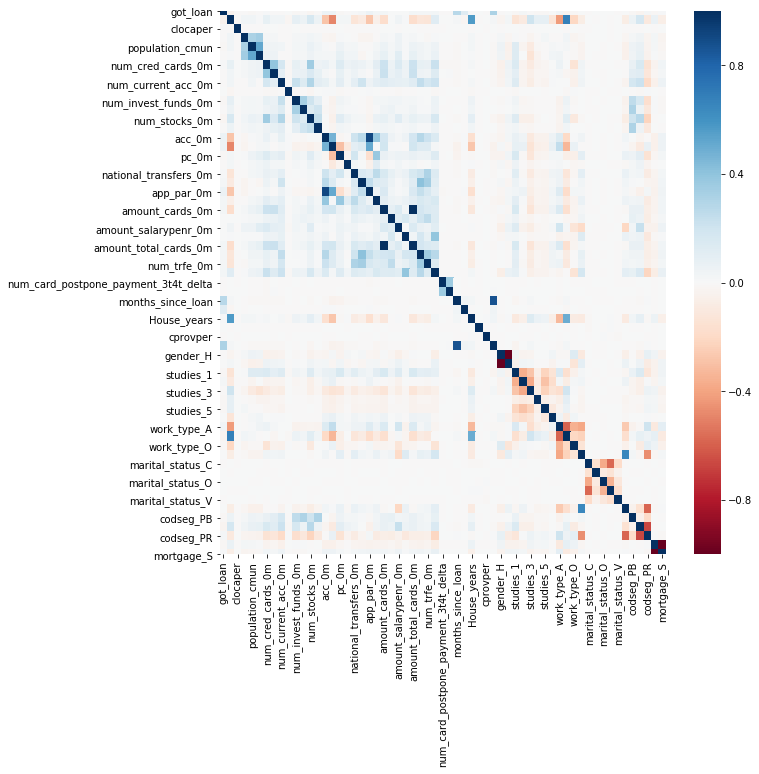

In [35]:
# Heatmap to get a quick view of the correlation between the features

'''Plot a dataframe with meaningful row and column labels 
https://seaborn.pydata.org/generated/seaborn.heatmap.html'''

plt.figure(figsize=(10,10))
sns.heatmap(total_clients_mod.corr(), cmap= 'RdBu')

### 3.2 Top varible absolute correlation <a class="anchor" id="3.2-bullet"></a>
[table of contents](#index-bullet)

In [36]:
# Top varibles absolute correlation 

'''List highest absolute correlation pairs from a correlation matrix. Unstack and order to get the most 
correlated pairs '''
'''set_option, allows displaying the number of rows we require in this particular analysis'''
pd.set_option('display.max_rows',15)
print("Top absolute Correlation pairs")
correla = total_clients_mod.corr().abs().unstack().sort_values(ascending=False).drop_duplicates().round(4)
correla[:15]

Top absolute Correlation pairs


amount_total_cards_0m  amount_cards_0m      1.0000
mortgage_S             mortgage_S           1.0000
mortgage_N             mortgage_S           0.9989
acc_0m                 app_par_0m           0.9088
previous_loans         months_since_loan    0.8703
work_type_J            age                  0.6861
codseg_PI              codseg_PR            0.6683
work_type_P            codseg_CN            0.6549
work_type_A            work_type_J          0.5895
codseg_PR              codseg_CN            0.5847
marital_status_C       marital_status_S     0.5729
House_years            age                  0.5660
disporent_cmun         population_cmun      0.5182
app_par_0m             mobile_0m            0.5151
House_years            work_type_J          0.4966
dtype: float64

### 3.3 Top correlated features with the dependent variable <a class="anchor" id="3.3-bullet"></a>
[table of contents](#index-bullet)

In [37]:
#Correlation with output variable
cor = total_clients_mod.corr()
cor_target = abs(cor['got_loan'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

got_loan             1.000000
months_since_loan    0.278317
previous_loans       0.314747
Name: got_loan, dtype: float64

### 3.4 Backward feature elimination   <a class="anchor" id="3.4-bullet"></a>
[table of contents](#index-bullet)

In [38]:
#Backward Elimination
warnings.simplefilter('ignore')
'''https://towardsdatascience.com/p-value-basics-with-python-code-ae5316197c52 definition of pvalue'''
#Adding constant column of ones, mandatory for sm.OLS model.Backward Elimination with pvalues 
total_clients_mod_fs = total_clients_mod.copy()

''' split dependent feature from the dataset'''
X_fs = total_clients_mod_fs.loc[:, total_clients_mod_fs.columns != 'got_loan']
y_fs = total_clients_mod_fs.loc[:, total_clients_mod_fs.columns == 'got_loan']

''' create iteration. drop features with pvalue higher than 0.05'''
cols = list(X_fs.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_fs[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_fs,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_ = cols
print(selected_features_)
print('the final number of features is :', len(selected_features_))

['age', 'population_cmun', 'num_cred_cards_0m', 'aveg_amount_cred_card_0m', 'num_stocks_0m', 'acc_0m', 'mobile_0m', 'pc_0m', 'tablet_0m', 'app_par_0m', 'web_par_0m', 'amount_cards_0m', 'amount_rec_0m', 'amount_total_cards_0m', 'num_rec_0m', 'aved_amount_postpone_payment_3t4t_delta', 'months_since_loan', 'car_years', 'House_years', 'cprovper', 'previous_loans', 'gender_H', 'gender_V', 'studies_1', 'studies_2', 'studies_3', 'work_type_A', 'work_type_J', 'work_type_O', 'work_type_P', 'codseg_PB', 'codseg_PI', 'mortgage_N']
the final number of features is : 33


In [39]:
# Featurea selection to include in the model. 

'''Since the final master´s work is about explaining why a specific custumer is selected by the model
and we know that Global features important may not be important in the local context, i am going to use the 
features selected previously with Backward Elimination to prove it and to give more information to the sales 
representatives''' 

features_to_model = ['got_loan',
                     'age', 
                     'population_cmun',
                     'num_cred_cards_0m', 'aveg_amount_cred_card_0m', 'amount_cards_0m', 'amount_total_cards_0m', 
                     'num_stocks_0m',
                     'acc_0m', 'mobile_0m', 'pc_0m', 'tablet_0m', 'app_par_0m', 'web_par_0m', 
                     'amount_rec_0m', 'num_rec_0m', 
                     'aved_amount_postpone_payment_3t4t_delta', 
                     'car_years', 
                     'House_years', 
                     'previous_loans',
                     'gender_V',
                     'studies_1', 'studies_2', 'studies_3',
                     'work_type_A', 'work_type_J', 'work_type_O', 'work_type_P',
                     'codseg_PB', 'codseg_PI',
                     'mortgage_N']                
         

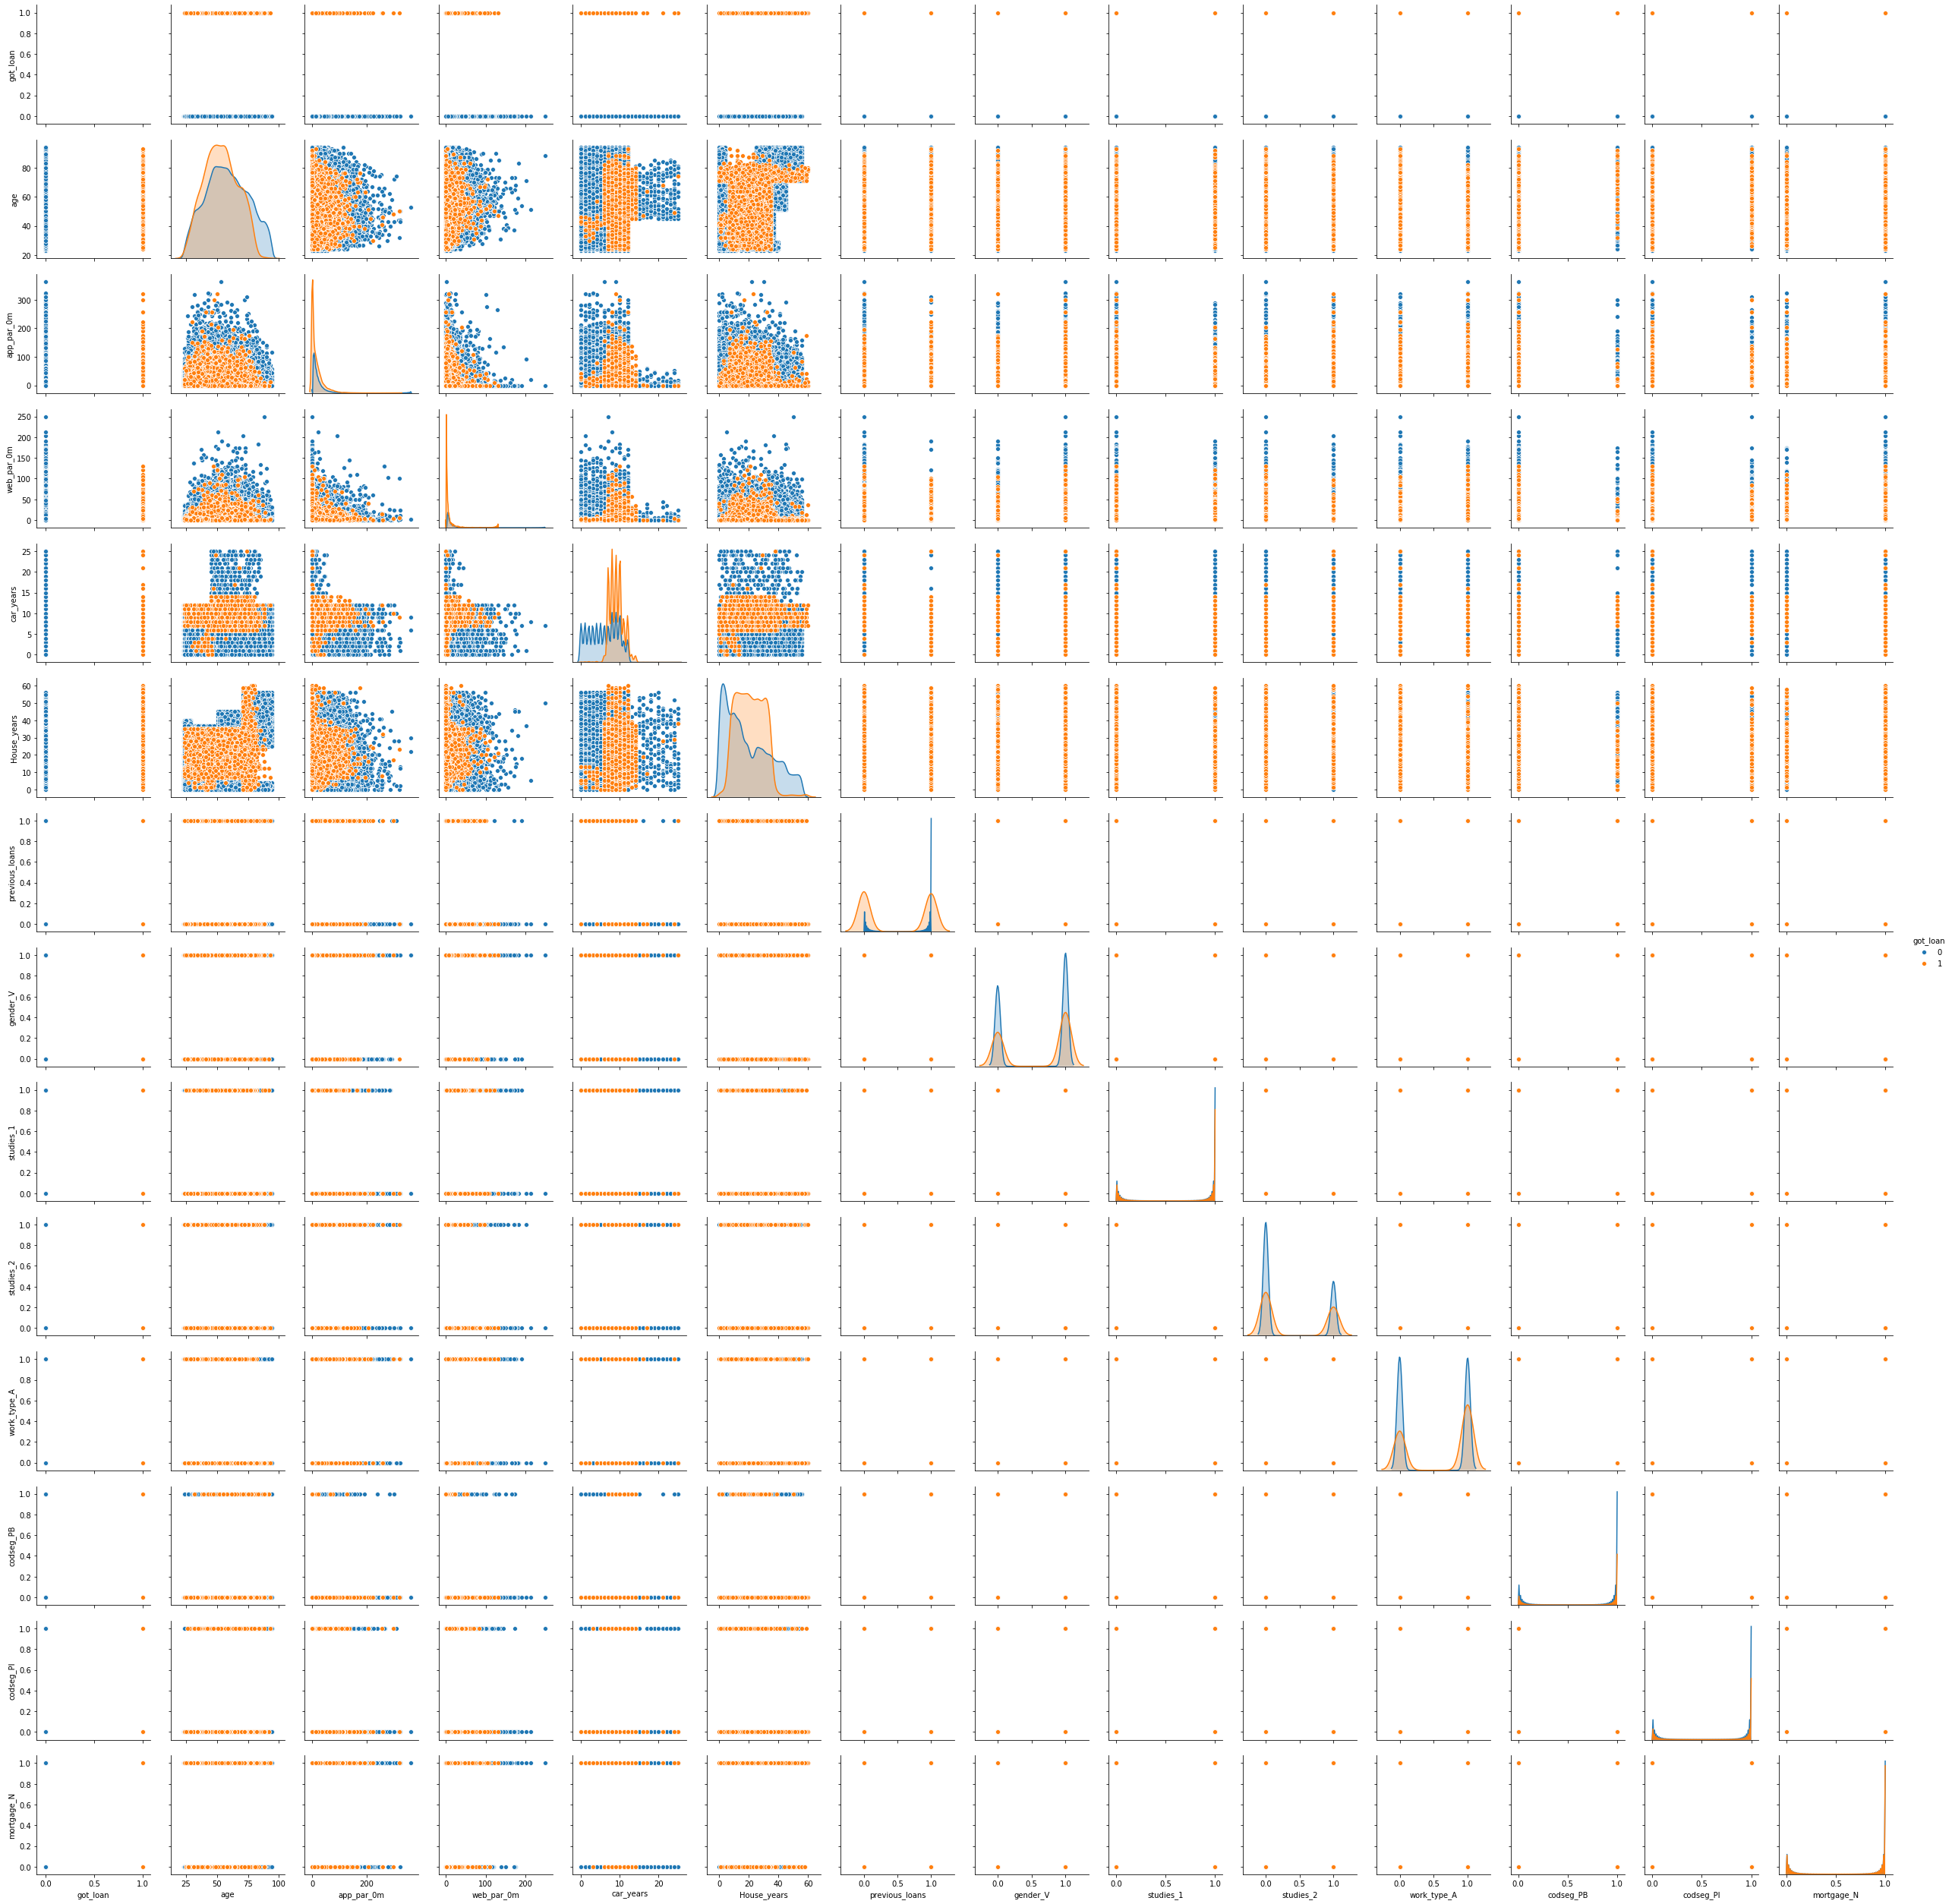

In [40]:
# Basic pairplot correlogram 

''' plot some of the features selected for the model'''

mini_total_clients_mod = total_clients_mod[['got_loan',
                                             'age', 
                                             'app_par_0m', 'web_par_0m', 
                                             'car_years', 
                                             'House_years', 
                                             'previous_loans',
                                             'gender_V',
                                             'studies_1', 'studies_2',
                                             'work_type_A', 
                                             'codseg_PB', 'codseg_PI',
                                             'mortgage_N']]
sns.pairplot(mini_total_clients_mod, hue = 'got_loan') 



### 4 Outliers <a class="anchor" id="forth-bullet"></a>
[table of contents](#index-bullet)

### 4.1 IQR (mean) <a class="anchor" id="4.1-bullet"></a>
[table of contents](#index-bullet)

In [41]:
# https://medium.com/datadriveninvestor/finding-outliers-in-dataset-using-python-efc3fce6ce32
# IQR does not work for outliers in this dataset due to the high data dispersion
''' Use features not factorized previously'''

col = ['age', 
       'population_cmun',
       'num_cred_cards_0m', 'aveg_amount_cred_card_0m', 'amount_cards_0m', 'amount_total_cards_0m', 
       'num_stocks_0m',
       'acc_0m', 'mobile_0m', 'pc_0m', 'tablet_0m', 'app_par_0m', 'web_par_0m', 
       'amount_rec_0m', 'num_rec_0m', 
       'aved_amount_postpone_payment_3t4t_delta', 
       'months_since_loan', 
       'car_years', 
       'House_years', 
       'cprovper']
'''Define Quantile 1 and 3
3 times the IQR above or bellow the Q1 or Q3 accodingly is considered a definitive outlier
Create a dataset with the instances with outliers in any feature'''

Q1 = total_clients_mod[col].quantile(0.25)
Q3 = total_clients_mod[col].quantile(0.75)
IQR = Q3 - Q1
total_clients_mod_out = total_clients_mod[col][~((total_clients_mod[col] < (Q1 - 3 * IQR)) |
                                            (total_clients_mod[col] > (Q3 + 3 * IQR))).any(axis=1)]
drop_outl = total_clients_mod_out.dropna()
drop_outl.append(drop_outl)
drop_outl
# Drop columns included in the outliers´ review  dataset
for c in col:
    n = total_clients_mod.drop(col, axis = 1)
# Concat both dataset to get all the columns back without outliers
total_clients_mod_new_IQR = pd.merge(n,drop_outl,left_index=True, right_index=True)

print('Dataset with outliers',total_clients_mod.shape)
print('Dataset without outliers',total_clients_mod_new_IQR.shape)

Dataset with outliers (395937, 61)
Dataset without outliers (163467, 61)


### 4.2 zScore (Standard deviation) <a class="anchor" id="4.2-bullet"></a>
[table of contents](#index-bullet)

In [42]:
# check for outliers with Zscore

'''We find the z score for each of the data points in the dataset and if the z score 
is greater than 3 then we can classify it as an outlier. Any point outside of
3 standard deviations would be an outlier'''

col = ['age', 
       'amount_cards_0m', 'amount_total_cards_0m', 
       'app_par_0m', 
       'months_since_loan', 
       'car_years', 
       'House_years']


final = total_clients_mod[col][~(np.abs(total_clients_mod[col]-total_clients_mod[col].mean()) > (3*total_clients_mod[col].std()))]
drop_outliers = final.dropna()
drop_outliers.append(drop_outliers)
# Drop columns included in the outliers´ review  dataset
for c in col:
    n = total_clients_mod.drop(col, axis = 1)
#concat both dataset to get all the columns back without outliers
total_clients_mod_new_Zscore = pd.merge(n,drop_outliers,left_index=True, right_index=True)

print('Dataset with outliers',total_clients_mod.shape)
print('Dataset without outliers',total_clients_mod_new_Zscore.shape)

Dataset with outliers (395937, 61)
Dataset without outliers (371986, 61)


### 5 Models  approach <a class="anchor" id="fifth-bullet"></a>
[table of contents](#index-bullet)

###  5.1 Dataset normalization | balanced| train,test & validation split <a class="anchor" id="5.1-bullet"></a>
[table of contents](#index-bullet)

In [43]:
# normalized data. 

total_clients_mod_ =total_clients_mod[features_to_model].copy()

'''apply list comprenhension only to the features we will be using for the models.This normalized is column-wise
and min-max normalization. Could also be used mean & std normalization method with Pandas'''

total_clients_mod_norm = total_clients_mod_[features_to_model].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

total_clients_mod_

got_loan  age  population_cmun  num_cred_cards_0m  \
0              0   34         689434.0                  0   
1              0   45         114238.0                  2   
2              0   67        1620809.0                  0   
3              0   40          15225.0                  2   
4              0   47          23222.0                  0   
...          ...  ...              ...                ...   
399995         0   53          23178.0                  0   
399996         0   89         787808.0                  0   
399997         0   41        3182981.0                  2   
399998         0   65          14756.0                  0   
399999         0   40              0.0                  2   

        aveg_amount_cred_card_0m  amount_cards_0m  amount_total_cards_0m  \
0                           0.00         71.85620               99.07560   
1                           0.00          0.00000                0.00000   
2                           0.00        309.63923              426.93174   
3                         194.15        100.24607              138.21966   
4                           0.00         38.21530               52.69140   
...                          ...              ...                    ...   
399995                      0.00          0.00000                0.00000   
399996                      0.00         14.29500               19.71000   
399997                    225.25       3792.08230             5228.53740   
399998                      0.00          0.00000                0.00000   
399999                     18.20       1338.21213             1845.13194   

        num_stocks_0m  acc_0m  mobile_0m     pc_0m  tablet_0m  app_par_0m  \
0                   0       1   1.000000  0.000000        0.0           1   
1                   0      19   1.000000  0.000000        0.0          19   
2                   0      15   1.000000  0.000000        0.0          14   
3                   1      13   1.000000  0.000000        0.0          11   
4                   0      15   1.000000  0.000000        0.0          15   
...               ...     ...        ...       ...        ...         ...   
399995              1      10   1.000000  0.000000        0.0          10   
399996              0       0   0.000000  0.000000        0.0           0   
399997              0      10   1.000000  0.000000        0.0           9   
399998              4       0   0.000000  0.000000        0.0           0   
399999              2      18   0.777778  0.222222        0.0          14   

        web_par_0m  amount_rec_0m  num_rec_0m  \
0                0       21.95279           1   
1                0      309.81457           3   
2                1     1075.44978           8   
3                2        0.00000           0   
4                0     2730.82250           4   
...            ...            ...         ...   
399995           0       49.31412           1   
399996           0      131.89648           5   
399997           1      489.71797           4   
399998           0     2876.40373          15   
399999           4      675.46292           7   

        aved_amount_postpone_payment_3t4t_delta  car_years  House_years  \
0                                          0.00         12           19   
1                                          0.00          2            4   
2                                        -98.33          3            1   
3                                          0.00         12            6   
4                                          0.00          5           10   
...                                         ...        ...          ...   
399995                                    83.49          0           17   
399996                                     0.00          2            0   
399997                                     0.00          2            1   
399998                                     0.00          9            1   
399999                 

In [44]:
# final features for the model

# non normalized

# total_clients_mod_f = total_clients_mod_new_Zscore.copy()
total_clients_mod_f = total_clients_mod_.copy()

# normalized
total_clients_mod_fn = total_clients_mod_norm.copy()

print('non normalized:', total_clients_mod_f.shape)
print('normalized:', total_clients_mod_fn.shape)
print('non normalized 1:', total_clients_mod_f[total_clients_mod_f.got_loan == 1].shape)
print('non normalized 0:', total_clients_mod_f[total_clients_mod_f.got_loan == 0].shape)
print('normalized 1:', total_clients_mod_fn[total_clients_mod_fn.got_loan == 1].shape)
print('normalized 0:', total_clients_mod_fn[total_clients_mod_fn.got_loan == 0].shape)


non normalized: (395937, 31)
normalized: (395937, 31)
non normalized 1: (7005, 31)
non normalized 0: (388932, 31)
normalized 1: (7005, 31)
normalized 0: (388932, 31)


### normalized train,test split

In [45]:
# normalized

# normalized
total_clients_mod_f90n =total_clients_mod_fn.sample(frac=0.9, replace=False, random_state=42)

# normalized
total_clients_mod_f10n =total_clients_mod_fn[~total_clients_mod_fn.index.isin(total_clients_mod_f90n.index)]

# Define the features and the target
X_n = total_clients_mod_f90n.loc[:, total_clients_mod_f90n.columns != 'got_loan']
y_n = total_clients_mod_f90n.loc[:, total_clients_mod_f90n.columns == 'got_loan']

# Split the dataset into train and test sklearn
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=.25, random_state=42)

print('X_train_n:' , X_train_n.shape)
print('X_test_n:',  X_test_n.shape)
print('y_train_n:' , y_train_n.shape)
print('y_test_n:' ,y_test_n.shape)
print(y_test_n.got_loan.value_counts())

X_train_n: (267257, 30)
X_test_n: (89086, 30)
y_train_n: (267257, 1)
y_test_n: (89086, 1)
0.0    87546
1.0     1540
Name: got_loan, dtype: int64


### normalized balanced

In [46]:
# normalized
# Define the features and the target
Xnb = total_clients_mod_f90n.loc[:, total_clients_mod_f90n.columns != 'got_loan']
ynb = total_clients_mod_f90n.loc[:, total_clients_mod_f90n.columns == 'got_loan']

print(Xnb.count())

age                         356343
population_cmun             356343
num_cred_cards_0m           356343
aveg_amount_cred_card_0m    356343
amount_cards_0m             356343
                             ...  
work_type_O                 356343
work_type_P                 356343
codseg_PB                   356343
codseg_PI                   356343
mortgage_N                  356343
Length: 30, dtype: int64


In [47]:
# # normalized balanced
# # under-over sampling   
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# # define oversampling strategy
# over = RandomOverSampler(sampling_strategy='minority',ratio = 0.1,random_state= 42)
# # fit and apply the transform
# Xnb_resampled, ynb_resampled = over.fit_resample(Xnb, ynb)
# # define undersampling strategy
# under = RandomUnderSampler(sampling_strategy='majority',ratio = 0.35,random_state= 42)
# # fit and apply the transform
# Xnb_resampled, ynb_resampled = under.fit_resample(Xnb_resampled, ynb_resampled)

# print('Dataset after resampling:') 
# print('Xb_resampled shape', Xnb_resampled.shape)
# print('yb_resampled shape', ynb_resampled.shape)
# yvals, counts = np.unique(ynb_resampled, return_counts=True)
# print('number of 0 and 1:',counts)


In [48]:
# normalized balanced
# undersampling   Synthetic Minority Oversampling Technique(SMOTENC )
warnings.simplefilter('ignore')
'''Undersampling to balance dataset 1/4'''
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification
from collections import Counter

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.30)
Xnb_resampled, ynb_resampled = undersample.fit_resample(Xnb, ynb)
# Xb_resampled = pd.DataFrame(Xb_resampled,columns=[Xb.columns])      
# yb_resampled = pd.DataFrame(yb_resampled,columns=[yb.columns])
# summarize class distribution
# print(Counter(ynb_resampled))
# print('Dataset after resampling:') 
# print(sorted(Counter(ynb_resampled).items())) 
print('Dataset after resampling:') 
# print(sorted(Counter(yb_resampled).items())) 
print('Xb_resampled shape', Xnb_resampled.shape)
print('yb_resampled shape', ynb_resampled.shape)
yvals, counts = np.unique(ynb_resampled, return_counts=True)
print('number of 0 and 1:',counts)

Dataset after resampling:
Xb_resampled shape (27265, 30)
yb_resampled shape (27265, 1)
number of 0 and 1: [20973  6292]


In [49]:
#### oversampling   Synthetic Minority Oversampling Technique(SMOTENC )

# smote_nc = SMOTENC(categorical_features=[0],sampling_strategy=0.2, random_state=42) 
# Xnb_resampled, ynb_resampled = smote_nc.fit_resample(Xnb, ynb) 

# print('Dataset after resampling:') 
# # print(sorted(Counter(yb_resampled).items())) 
# print('Xnb_resampled shape', Xnb_resampled.shape)
# print('ynb_resampled shape', ynb_resampled.shape)
# yvals, counts = np.unique(ynb_resampled, return_counts=True)
# print('number of 0 and 1:',counts)

In [50]:
# normalized balanced
# Split the dataset into train and test sklearn
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(Xnb_resampled, ynb_resampled, test_size=.25, random_state=42)

print('X_train_nb:' , X_train_nb.shape)
print('X_test_nb:',  X_test_nb.shape)
print('y_train_nb:' , y_train_nb.shape)
print('y_test_nb:' ,y_test_nb.shape)
# number of ceros and ones rebalanced

#ceros
ynb_resampled_count0 = filter(lambda x: x == 0, ynb_resampled)
i =0
for x in ynb_resampled_count0:
    i +=1
print ('number of ceros ynb_resampled:', i)
#ones 
ynb_resampled_count1 = filter(lambda x: x == 1, ynb_resampled)
i =0
for x in ynb_resampled_count1:
    i +=1
print ('number of ones ynb_resampled:', i)

X_train_nb: (20448, 30)
X_test_nb: (6817, 30)
y_train_nb: (20448, 1)
y_test_nb: (6817, 1)
number of ceros ynb_resampled: 20973
number of ones ynb_resampled: 6292


### Dataset non normalized 


In [51]:
# datasets to model 90%
# non normalized
total_clients_mod_f90 =total_clients_mod_f.sample(frac=0.9, replace=False, random_state=42)


# validation dataset 10%

# non normalized
total_clients_mod_f10 = total_clients_mod_f[~total_clients_mod_f.index.isin(total_clients_mod_f90.index)]


print('90% of clients')
print('non normalized 1:', total_clients_mod_f90[total_clients_mod_f90.got_loan == 1].shape)
print('non normalized 0:', total_clients_mod_f90[total_clients_mod_f90.got_loan == 0].shape)
print('normalized 1:', total_clients_mod_f90n[total_clients_mod_f90n.got_loan == 1].shape)
print('normalized 0:', total_clients_mod_f90n[total_clients_mod_f90n.got_loan == 0].shape)
print('10% of clients')
print('non normalized val 1', total_clients_mod_f10[total_clients_mod_f10.got_loan == 1].shape)
print('non normalized val 0:', total_clients_mod_f10[total_clients_mod_f10.got_loan == 0].shape)
print('normalized val 1:', total_clients_mod_f10n[total_clients_mod_f10n.got_loan == 1].shape)
print('normalized val 0:', total_clients_mod_f10n[total_clients_mod_f10n.got_loan == 0].shape)

90% of clients
non normalized 1: (6292, 31)
non normalized 0: (350051, 31)
normalized 1: (6292, 31)
normalized 0: (350051, 31)
10% of clients
non normalized val 1 (713, 31)
non normalized val 0: (38881, 31)
normalized val 1: (713, 31)
normalized val 0: (38881, 31)


In [52]:
total_clients_mod_f90n[total_clients_mod_f90n.got_loan != 0].sample(20)

got_loan       age  population_cmun  num_cred_cards_0m  \
295478       1.0  0.239437         0.002392                0.2   
278868       1.0  0.619718         0.003244                0.2   
278132       1.0  0.394366         0.028998                0.2   
9226         1.0  0.563380         0.030304                0.2   
315315       1.0  0.267606         0.018778                0.0   
...          ...       ...              ...                ...   
154364       1.0  0.408451         0.011816                0.1   
50711        1.0  0.774648         0.000639                0.1   
276979       1.0  0.380282         0.001676                0.0   
241228       1.0  0.676056         0.009721                0.1   
55931        1.0  0.309859         0.021006                0.1   

        aveg_amount_cred_card_0m  amount_cards_0m  amount_total_cards_0m  \
295478                  0.168205         0.002630               0.002630   
278868                  0.169830         0.012872               0.012872   
278132                  0.172559         0.000000               0.000000   
9226                    0.172767         0.001825               0.001825   
315315                  0.167857         0.000075               0.000075   
...                          ...              ...                    ...   
154364                  0.167012         0.002584               0.002584   
50711                   0.169202         0.000668               0.000668   
276979                  0.167857         0.020754               0.020754   
241228                  0.166793         0.006097               0.006097   
55931                   0.167857         0.010491               0.010491   

        num_stocks_0m    acc_0m  mobile_0m     pc_0m  tablet_0m  app_par_0m  \
295478       0.000000  0.009074   1.000000  0.000000        0.0    0.011019   
278868       0.038462  0.000000   0.000000  0.000000        0.0    0.000000   
278132       0.038462  0.186933   1.000000  0.000000        0.0    0.278237   
9226         0.000000  0.000000   0.000000  0.000000        0.0    0.000000   
315315       0.000000  0.001815   1.000000  0.000000        0.0    0.002755   
...               ...       ...        ...       ...        ...         ...   
154364       0.038462  0.052632   1.000000  0.000000        0.0    0.077135   
50711        0.000000  0.000000   0.000000  0.000000        0.0    0.000000   
276979       0.000000  0.059891   1.000000  0.000000        0.0    0.088154   
241228       0.000000  0.000000   0.000000  0.000000        0.0    0.000000   
55931        0.000000  0.025408   0.857143  0.142857        0.0    0.033058   

        web_par_0m  amount_rec_0m  num_rec_0m  \
295478       0.004       0.000110    0.002160   
278868       0.000       0.001809    0.015119   
278132       0.000       0.000667    0.010799   
9226         0.000       0.000494    0.004320   
315315       0.000       0.000000    0.000000   
...            ...            ...         ...   
154364       0.004       0.000046    0.002160   
50711        0.000       0.000068    0.002160   
276979       0.004       0.000626    0.015119   
241228       0.000       0.001228    0.012959   
55931        0.008       0.000050    0.004320   

        aved_amount_postpone_payment_3t4t_delta  car_years  House_years  \
295478                                 0.410892       0.48     0.116667   
278868                                 0.410892       0.40     0.450000   
278132                                 0.410892       0.28     0.366667   
9226                                   0.410892       0.24     0.450000   
315315                                 0.410892       0.36     0.316667   
...                                         ...        ...          ...   
154364                                 0.410892       0.36     0.266667   
50711                                  0.410892       0.36     0.150000   
276979                                 0.410892       0.40     0.450000   
241228        

### non normalized-Train & Test split

In [53]:
### non normalized

# Define the features and the target
X = total_clients_mod_f90.loc[:, total_clients_mod_f90.columns != 'got_loan']
y = total_clients_mod_f90.loc[:, total_clients_mod_f90.columns == 'got_loan']

# Split the dataset into train and test sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
print('X:' , X.shape)
print('X_train:' , X_train.shape)
print('X_test:',  X_test.shape)
print('y_train:' , y_train.shape)
print('y_test:' ,y_test.shape)
print('nº of 1 ',y_test[y_test.got_loan ==1].shape)
print('nº of 0 ', y_test[y_test.got_loan ==0].shape)

X: (356343, 30)
X_train: (267257, 30)
X_test: (89086, 30)
y_train: (267257, 1)
y_test: (89086, 1)
nº of 1  (1540, 1)
nº of 0  (87546, 1)


### non normalized balanced

In [54]:
Xb = total_clients_mod_f90.loc[:, total_clients_mod_f90.columns != 'got_loan']
yb = total_clients_mod_f90.loc[:, total_clients_mod_f90.columns == 'got_loan']
print(Xb.count())

age                         356343
population_cmun             356343
num_cred_cards_0m           356343
aveg_amount_cred_card_0m    356343
amount_cards_0m             356343
                             ...  
work_type_O                 356343
work_type_P                 356343
codseg_PB                   356343
codseg_PI                   356343
mortgage_N                  356343
Length: 30, dtype: int64


In [55]:
# # non normalized balanced
# #Synthetic Minority Oversampling Technique(SMOTENC )
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# # define oversampling strategy
# over = RandomOverSampler(sampling_strategy='minority',ratio = 0.1, random_state= 42)
# # fit and apply the transform
# Xb_resampled, yb_resampled = over.fit_resample(Xb, yb)
# # define undersampling strategy
# under = RandomUnderSampler(sampling_strategy='mayority',ratio = 0.35,random_state= 42)
# # fit and apply the transform
# Xb_resampled, yb_resampled = under.fit_resample(Xb_resampled, yb_resampled)

# print('Dataset after resampling:') 
# print('Xb_resampled shape', Xb_resampled.shape)
# print('yb_resampled shape', yb_resampled.shape)
# yvals, counts = np.unique(yb_resampled, return_counts=True)
# print('number of 0 and 1:',counts)


In [56]:
# non normalized balanced
warnings.simplefilter('ignore')
# undersampling   Synthetic Minority Oversampling Technique(SMOTENC )
'''Undersampling to balance dataset 1/4'''
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification
from collections import Counter

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.30)
Xb_resampled, yb_resampled = undersample.fit_resample(Xb, yb)
# Xb_resampled = pd.DataFrame(Xb_resampled,columns=[Xb.columns])      
# yb_resampled = pd.DataFrame(yb_resampled,columns=[yb.columns])
# summarize class distribution
# print(Counter(yb_resampled))
# print('Dataset after resampling:') 
# print(sorted(Counter(yb_resampled).items())) 
print('Dataset after resampling:') 
# print(sorted(Counter(yb_resampled).items())) 
print('Xb_resampled shape', Xb_resampled.shape)
print('yb_resampled shape', yb_resampled.shape)
yvals, counts = np.unique(yb_resampled, return_counts=True)
print('number of 0 and 1:',counts)

Dataset after resampling:
Xb_resampled shape (27265, 30)
yb_resampled shape (27265, 1)
number of 0 and 1: [20973  6292]


In [57]:
# oversampling   Synthetic Minority Oversampling Technique(SMOTENC )

# smote_nc = SMOTENC(categorical_features=[0],sampling_strategy=0.2, random_state=42) 
# Xb_resampled, yb_resampled = smote_nc.fit_resample(Xb, yb) 


# print('Dataset after resampling:') 
# print('Xb_resampled shape', Xb_resampled.shape)
# print('yb_resampled shape', yb_resampled.shape)
# yvals, counts = np.unique(yb_resampled, return_counts=True)
# print('number of 0 and 1:',counts)

In [58]:
# Split the dataset into train and test sklearn- dataset balanced
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(Xb_resampled, yb_resampled, test_size=.25, random_state=42)

print('X_train_b:' , X_train_b.shape)
print('X_test_b:',  X_test_b.shape)
print('y_train_b:' , y_train_b.shape)
print('y_test_b:' ,y_test_b.shape)
# number of ceros and ones rebalanced

#ceros
yb_resampled_count0 = filter(lambda x: x == 0, yb_resampled)
i =0
for x in yb_resampled_count0:
    i +=1
print ('number of ceros yb_resampled:', i)
#ones 
yb_resampled_count1 = filter(lambda x: x == 1, yb_resampled)
i =0
for x in yb_resampled_count1:
    i +=1
print ('number of ones yb_resampled:', i)


X_train_b: (20448, 30)
X_test_b: (6817, 30)
y_train_b: (20448, 1)
y_test_b: (6817, 1)
number of ceros yb_resampled: 20973
number of ones yb_resampled: 6292


### validation dataset

In [59]:
# normalized

X_val_n = total_clients_mod_f10n.loc[:, total_clients_mod_f10n.columns != 'got_loan']
y_val_n = total_clients_mod_f10n.loc[:, total_clients_mod_f10n.columns == 'got_loan']

y_val_n['got_loan'].value_counts()

0.0    38881
1.0      713
Name: got_loan, dtype: int64

In [60]:
### non normalized

X_val = total_clients_mod_f10.loc[:, total_clients_mod_f10.columns != 'got_loan']
y_val = total_clients_mod_f10.loc[:, total_clients_mod_f10.columns == 'got_loan']

y_val['got_loan'].value_counts()

0    38881
1      713
Name: got_loan, dtype: int64

### 5.2 Visualization unbalanced and balanced dataset <a class="anchor" id="5.2-bullet"></a>
[table of contents](#index-bullet)

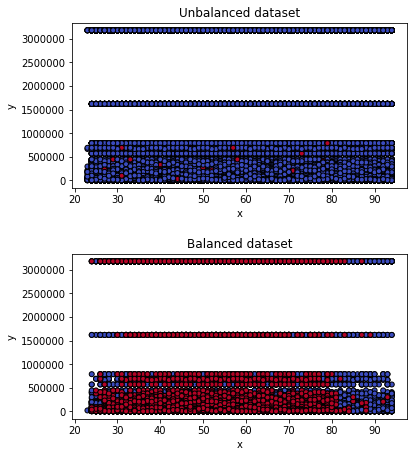

In [61]:
# visualization unbalanced

''' convert to an array with numpy'''
X_arr = X.copy()
X_arr = X_arr.to_numpy(dtype='float')
y_arr = y.copy()
y_arr = y_arr.to_numpy(dtype='uint8')
y_arr_list = []
for sublist in y_arr:
    for item in sublist:
        y_arr_list.append(item)
        
y_arr_b = yb_resampled.copy()
y_arr_list_b = []
for sublist in y_arr_b:
    for item in sublist:
        y_arr_list_b.append(item)


'''plot both dataset'''
# plt.figure(figsize=(30,15))

plt.subplot(2, 1, 1)

plt.title('Unbalanced dataset')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(-10000,20000)
plt.scatter(X_arr[:, 0], X_arr[:, 1], marker='o', c=y_arr_list,
           s=25, edgecolor='k', cmap=plt.cm.coolwarm)

# visualization balanced
plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace = 0.4,top = 1.5)
plt.title('Balanced dataset')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(-10000,20000)
plt.scatter(Xb_resampled[:, 0],Xb_resampled[:, 1],  marker='o', c=y_arr_list_b,
           s=25, edgecolor='k', cmap=plt.cm.coolwarm)
plt.show()

### 6. Models approach <a class="anchor" id="sixth-bullet"></a>
[table of contents](#index-bullet)

### 6.1 Logistic Regression <a class="anchor" id="6.1-bullet"></a>
[table of contents](#index-bullet)

### 6.1.1 balanced 

[[3934 1290]
 [ 917  676]]
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      5224
           1       0.34      0.42      0.38      1593

    accuracy                           0.68      6817
   macro avg       0.58      0.59      0.58      6817
weighted avg       0.70      0.68      0.69      6817

0.6762505500953498
=== roc_curve ===
0.6484304177253278


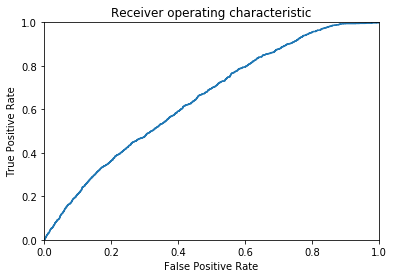

In [62]:
model_logreg_b = LogisticRegression(random_state=42,class_weight='balanced')

model_logreg_b.fit(X_train_b,y_train_b)
# Predict values using the random forest classifier model
y_pred_logreg_b = model_logreg_b.predict(X_test_b)

print(confusion_matrix(y_test_b,y_pred_logreg_b))
print(classification_report(y_test_b,y_pred_logreg_b))
print(accuracy_score(y_test_b,y_pred_logreg_b))

# roc_auc_score
y_pred_logreg_b2 = model_logreg_b.predict_proba(X_test_b)
y_pred_logreg_b2 = [p[1] for p in y_pred_logreg_b2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_logreg_b2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_logreg_b2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

logistic regresion normalized balanced validation


=== Confusion Matrix ===
[[29318  9563]
 [  408   305]]
=== classification_report ===
              precision    recall  f1-score   support

           0       0.99      0.75      0.85     38881
           1       0.03      0.43      0.06       713

    accuracy                           0.75     39594
   macro avg       0.51      0.59      0.46     39594
weighted avg       0.97      0.75      0.84     39594

=== accuracy_score ===
0.7481689144819922
=== roc_curve ===
0.6490273681124261


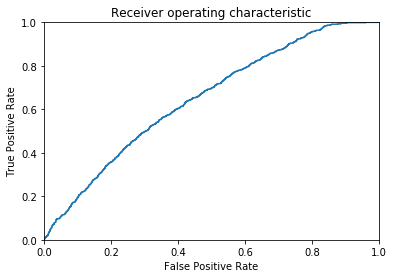

In [63]:
#validation
y_pred_b_logreg_val_b = model_logreg_b.predict(X_val)

print("logistic regresion normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_b_logreg_val_b))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_b_logreg_val_b))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_b_logreg_val_b))

# roc_auc_score validation dataset
y_pred_b_logreg_val_b2 = model_logreg_b.predict_proba(X_val)
y_pred_b_logreg_val_b2 = [p[1] for p in y_pred_b_logreg_val_b2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val,y_pred_b_logreg_val_b2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val,y_pred_b_logreg_val_b2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

### 6.1.2 normalized dataset-balanced

[[4206 1018]
 [ 392 1201]]
              precision    recall  f1-score   support

         0.0       0.91      0.81      0.86      5224
         1.0       0.54      0.75      0.63      1593

    accuracy                           0.79      6817
   macro avg       0.73      0.78      0.74      6817
weighted avg       0.83      0.79      0.80      6817

0.7931641484523985
=== roc_curve ===
0.8884131522962733


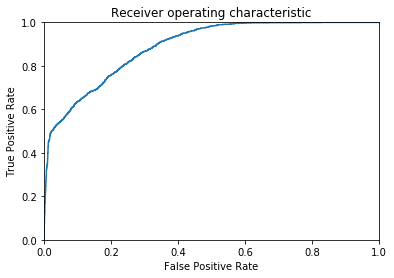

In [64]:
warnings.simplefilter('ignore')
model_logreg_nb = LogisticRegression(random_state=42,class_weight='balanced')

model_logreg_nb.fit(X_train_nb,y_train_nb)
# Predict values using the random forest classifier model
y_pred_logreg_nb = model_logreg_nb.predict(X_test_nb)

print(confusion_matrix(y_test_nb,y_pred_logreg_nb))
print(classification_report(y_test_nb,y_pred_logreg_nb))
print(accuracy_score(y_test_nb,y_pred_logreg_nb))

# roc_auc_score
y_pred_logreg_nb2 = model_logreg_nb.predict_proba(X_test_nb)
y_pred_logreg_nb2 = [p[1] for p in y_pred_logreg_nb2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,y_pred_logreg_nb2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,y_pred_logreg_nb2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

logistic regresion normalized balanced validation


=== Confusion Matrix ===
[[31171  7710]
 [  194   519]]
=== classification_report ===
              precision    recall  f1-score   support

         0.0       0.99      0.80      0.89     38881
         1.0       0.06      0.73      0.12       713

    accuracy                           0.80     39594
   macro avg       0.53      0.76      0.50     39594
weighted avg       0.98      0.80      0.87     39594

=== accuracy_score ===
0.8003737940091933
=== roc_curve ===
0.8815604256999807


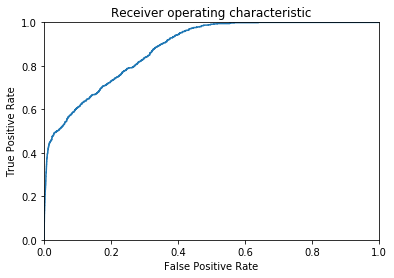

In [65]:
#validation
y_pred_b_logreg_val_n = model_logreg_nb.predict(X_val_n)

print("logistic regresion normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val_n,y_pred_b_logreg_val_n))
print("=== classification_report ===")
print(classification_report(y_val_n,y_pred_b_logreg_val_n))
print("=== accuracy_score ===")
print(accuracy_score(y_val_n,y_pred_b_logreg_val_n))

# roc_auc_score validation dataset
y_pred_b_logreg_val_n2 = model_logreg_nb.predict_proba(X_val_n)
y_pred_b_logreg_val_n2 = [p[1] for p in y_pred_b_logreg_val_n2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_n,y_pred_b_logreg_val_n2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_n,y_pred_b_logreg_val_n2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

### 6.2 Decision Tree Classifier <a class="anchor" id="6.2-bullet"></a>
[table of contents](#index-bullet)

In [68]:
# To find the best combination of hyper-parameters using Randomized Search 

# el que el max depth sea muy elevado no significa que va a llegar a eso. Esa cifra será el máximo.
from scipy.stats import randint as sp_randint
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, X_train_b.shape[1]),
              "min_samples_split": sp_randint(2, 11)}
n_iter_search = 20

# creo la instancia
clfrs = RandomizedSearchCV(tree.DecisionTreeClassifier(), 
                                   param_distributions=param_dist,
                                   scoring='neg_mean_squared_error',
                                   cv=5 , n_jobs=1, verbose=1,
                                   n_iter=n_iter_search)
# ahora lo entreno
clfrs.fit(X_train_b, y_train_b)


clfrs.best_params_, clfrs.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.8s finished


({'max_depth': 3, 'max_features': 23, 'min_samples_split': 10},
 -0.12651604489593105)

### 6.2.1 non normalized dataset-balanced

[[4620  604]
 [ 285 1308]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      5224
           1       0.68      0.82      0.75      1593

    accuracy                           0.87      6817
   macro avg       0.81      0.85      0.83      6817
weighted avg       0.88      0.87      0.87      6817

0.8695907290597037
=== roc_curve ===
0.9064642857486187


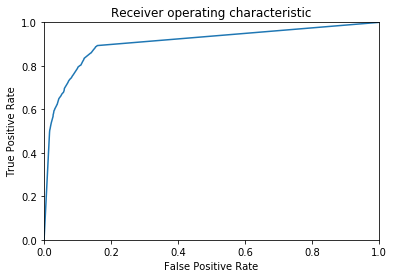

In [69]:
dt_clients_file_num_b = DecisionTreeClassifier(min_samples_split=6,max_depth = None ,max_features=11,
                                               min_samples_leaf=6,random_state=42,
                                               class_weight="balanced")
dt_clients_file_num_b.fit(X_train_b,y_train_b)
# Predict values using the random forest classifier model
y_pred_dt_b = dt_clients_file_num_b.predict(X_test_b)

print(confusion_matrix(y_test_b,y_pred_dt_b))
print(classification_report(y_test_b,y_pred_dt_b))
print(accuracy_score(y_test_b,y_pred_dt_b))

# roc_auc_score 
y_pred_dt_b2 = dt_clients_file_num_b.predict_proba(X_test_b)
y_pred_dt_b2 = [p[1] for p in y_pred_dt_b2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_dt_b2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_dt_b2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


decision tree classifier non normalized balanced validation


=== Confusion Matrix ===
[[33785  5096]
 [  127   586]]
=== classification_report ===
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     38881
           1       0.10      0.82      0.18       713

    accuracy                           0.87     39594
   macro avg       0.55      0.85      0.56     39594
weighted avg       0.98      0.87      0.91     39594

=== accuracy_score ===
0.8680860736475223
=== roc_curve ===
0.8952015018458342


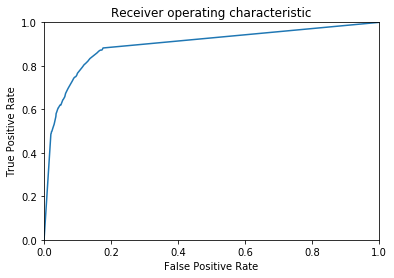

In [70]:

#validation
y_pred_dt_b_val = dt_clients_file_num_b.predict(X_val)

print("decision tree classifier non normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_dt_b_val))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_dt_b_val))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_dt_b_val))

# roc auc  validation dataset

y_pred_dt_b_val2 = dt_clients_file_num_b.predict_proba(X_val)
y_pred_dt_b_val2 = [p[1] for p in y_pred_dt_b_val2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val,y_pred_dt_b_val2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val,y_pred_dt_b_val2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


### 6.2.2 normalized dataset-balanced

In [71]:
# To find the best combination of hyper-parameters using Randomized Search 

# el que el max depth sea muy elevado no significa que va a llegar a eso. Esa cifra será el máximo.
from scipy.stats import randint as sp_randint
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, X_train_nb.shape[1]),
              "min_samples_split": sp_randint(2, 11)}
n_iter_search = 20

# creo la instancia
clfrs = RandomizedSearchCV(tree.DecisionTreeClassifier(), 
                                   param_distributions=param_dist,
                                   scoring='neg_mean_squared_error',
                                   cv=5 , n_jobs=1, verbose=1,
                                   n_iter=n_iter_search)
# ahora lo entreno
clfrs.fit(X_train_nb, y_train_nb)


clfrs.best_params_, clfrs.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.1s finished


({'max_depth': None, 'max_features': 24, 'min_samples_split': 8},
 -0.12558712892422333)

[[4620  604]
 [ 273 1320]]
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      5224
         1.0       0.69      0.83      0.75      1593

    accuracy                           0.87      6817
   macro avg       0.82      0.86      0.83      6817
weighted avg       0.88      0.87      0.88      6817

0.8713510341792577
0.8565025105048985
=== roc_curve ===
0.9028546238376357


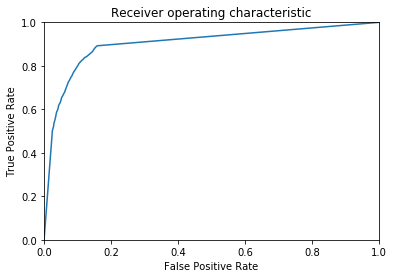

In [72]:
# Training a Decision Tree Model 

dt_clients_file_num_nb = DecisionTreeClassifier(min_samples_split=9,max_depth = None,max_features=22,
                                                min_samples_leaf=6,random_state=42,class_weight="balanced")

# fitting the decision tree model on the training set
dt_clients_file_num_nb.fit(X_train_nb,y_train_nb)
# Predict values using the random forest classifier model
y_pred_dt_nb = dt_clients_file_num_nb.predict(X_test_nb)

# Evaluation 
print(confusion_matrix(y_test_nb,y_pred_dt_nb))
print(classification_report(y_test_nb,y_pred_dt_nb))
print(accuracy_score(y_test_nb,y_pred_dt_nb))
print(roc_auc_score(y_test_nb,y_pred_dt_nb))

# roc auc  test dataset

y_pred_dt_nb2 = dt_clients_file_num_nb.predict_proba(X_test_nb)
y_pred_dt_nb2 = [p[1] for p in y_pred_dt_nb2 ]

print("=== roc_curve ===")
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,y_pred_dt_nb2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,y_pred_dt_nb2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

logistic regresion normalized balanced validation


=== Confusion Matrix ===
[[34230  4651]
 [  129   584]]
=== classification_report ===
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93     38881
         1.0       0.11      0.82      0.20       713

    accuracy                           0.88     39594
   macro avg       0.55      0.85      0.57     39594
weighted avg       0.98      0.88      0.92     39594

=== accuracy_score ===
0.8792746375713492
=== roc_curve ===
0.8977123818629816


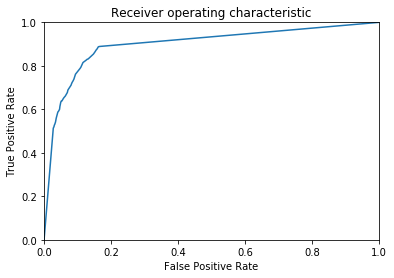

In [73]:
#validation
y_pred_b_val_nb = dt_clients_file_num_nb.predict(X_val_n)


print("logistic regresion normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val_n,y_pred_b_val_nb))
print("=== classification_report ===")
print(classification_report(y_val_n,y_pred_b_val_nb))
print("=== accuracy_score ===")
print(accuracy_score(y_val_n,y_pred_b_val_nb))

# roc auc  validation dataset

y_pred_b_val_nb2 = dt_clients_file_num_nb.predict_proba(X_val_n)
y_pred_b_val_nb2 = [p[1] for p in y_pred_b_val_nb2 ]

print("=== roc_curve ===")
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_n,y_pred_b_val_nb2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_n,y_pred_b_val_nb2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [74]:
# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = X.columns # no lo hago con resample ver si es correcto
feature_importance['importance'] = dt_clients_file_num_nb.feature_importances_

# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head(20)

variable  importance
16          car_years    0.413032
17        House_years    0.219498
18     previous_loans    0.119463
0                 age    0.090990
13      amount_rec_0m    0.025756
..                ...         ...
6       num_stocks_0m    0.003195
9               pc_0m    0.003119
8           mobile_0m    0.003052
20          studies_1    0.002606
2   num_cred_cards_0m    0.002513

[20 rows x 2 columns]

### 6.3 Random forest classifier <a class="anchor" id="6.3-bullet"></a>
[table of contents](#index-bullet)

### 6.3.1 RF non normalized-balanced

In [75]:
# specify parameters and distributions to sample from
warnings.simplefilter('ignore')
'''The randint module will help to initialize random values for the parameters that we want to specify.
It will be clearer after we define the parameter distribution that we want to use in our randomized search.'''

from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, X_train_b.shape[1]),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "n_estimators": sp_randint(100, 500)}
        
rfclassifier = RandomForestClassifier(random_state = 42)

random_search = RandomizedSearchCV(rfclassifier, param_distributions=param_dist,
                                   n_iter=10, cv=3, iid=False, random_state=42)
random_search.fit(X_train_b, y_train_b)
print(random_search.best_params_)

{'bootstrap': True, 'max_depth': None, 'max_features': 25, 'min_samples_split': 4, 'n_estimators': 406}


Mean ROC AUC: 0.963
[[5017  207]
 [ 389 1204]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      5224
           1       0.85      0.76      0.80      1593

    accuracy                           0.91      6817
   macro avg       0.89      0.86      0.87      6817
weighted avg       0.91      0.91      0.91      6817

0.9125715123954818
=== roc_curve ===
0.9676451651511349


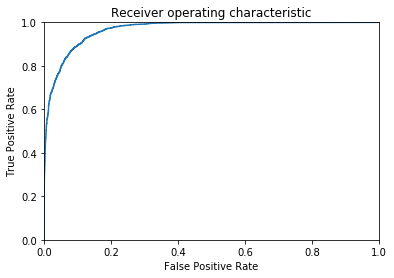

In [76]:
## balanced 
warnings.simplefilter('ignore')
rfclassifier_b = RandomForestClassifier(n_estimators = 288,criterion = 'gini',random_state = 42, 
                                        max_depth = None,max_features = 29,min_samples_split=4)
# fitting the rf model on the training set
rfclassifier_b.fit(X_train_b,y_train_b)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores_b = cross_val_score(rfclassifier_b, Xb_resampled, yb_resampled, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores_b))

# Predict values using the random forest classifier model
y_pred_rf_b = rfclassifier_b.predict(X_test_b)

print(confusion_matrix(y_test_b,y_pred_rf_b))
print(classification_report(y_test_b,y_pred_rf_b))
print(accuracy_score(y_test_b,y_pred_rf_b))

# roc auc  
y_pred_rf_b2 = rfclassifier_b.predict_proba(X_test_b)
y_pred_rf_b2 = [p[1] for p in y_pred_rf_b2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_rf_b2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_rf_b2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


Random Forest classifier non normalized balanced validation


=== Confusion Matrix ===
[[36898  1983]
 [  176   537]]
=== classification_report ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     38881
           1       0.21      0.75      0.33       713

    accuracy                           0.95     39594
   macro avg       0.60      0.85      0.65     39594
weighted avg       0.98      0.95      0.96     39594

=== accuracy_score ===
0.945471536091327
=== roc_curve ===
0.9613864947646743


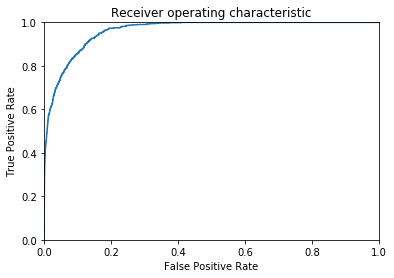

In [77]:

#validation
y_pred_rf_b_val = rfclassifier_b.predict(X_val)

print("Random Forest classifier non normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_rf_b_val))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_rf_b_val))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_rf_b_val))

# roc auc  validation dataset

y_pred_rf_b_val2 = rfclassifier_b.predict_proba(X_val)
y_pred_rf_b_val2 = [p[1] for p in y_pred_rf_b_val2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val,y_pred_rf_b_val2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val,y_pred_rf_b_val2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


### 6.3.2 RF normalized- balanced¶

In [78]:
# specify parameters and distributions to sample from
warnings.simplefilter('ignore')
'''The randint module will help to initialize random values for the parameters that we want to specify.
It will be clearer after we define the parameter distribution that we want to use in our randomized search.'''

from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, X_train_nb.shape[1]),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "n_estimators": sp_randint(100, 500)}
        
rfclassifier = RandomForestClassifier(random_state = 42)

random_search = RandomizedSearchCV(rfclassifier, param_distributions=param_dist,
                                   n_iter=10, cv=3, iid=False, random_state=42)
random_search.fit(X_train_nb, y_train_nb)
print(random_search.best_params_)

{'bootstrap': True, 'max_depth': None, 'max_features': 29, 'min_samples_split': 9, 'n_estimators': 288}


Mean ROC AUC: 0.962
[[4990  234]
 [ 405 1188]]
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      5224
         1.0       0.84      0.75      0.79      1593

    accuracy                           0.91      6817
   macro avg       0.88      0.85      0.86      6817
weighted avg       0.90      0.91      0.90      6817

0.9062637523837466
=== roc_curve ===
0.7147170839305574


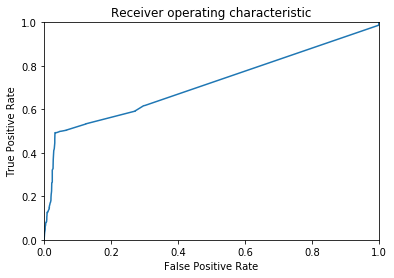

In [79]:
# normalized balanced
warnings.simplefilter('ignore')
rfclassifier_nb = RandomForestClassifier(n_estimators = 288,criterion = 'gini',random_state = 42, 
                                        max_depth = None,max_features = 29,min_samples_split=4)
rfclassifier_nb.fit(X_train_nb,y_train_nb)
# fitting the rf model on the training set
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores_nb = cross_val_score(rfclassifier_nb, Xnb_resampled, ynb_resampled, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores_nb))

# Predict values using the random forest classifier model
y_pred_rf_nb = rfclassifier_nb.predict(X_test_nb)

print(confusion_matrix(y_test_nb,y_pred_rf_nb))
print(classification_report(y_test_nb,y_pred_rf_nb))
print(accuracy_score(y_test_nb,y_pred_rf_nb))

# roc auc  validation dataset

y_pred_rf_nb2 = rfclassifier_b.predict_proba(X_test_nb)
y_pred_rf_nb2 = [p[1] for p in y_pred_rf_nb2]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,y_pred_rf_nb2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,y_pred_rf_nb2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

Random Forest classifier non normalized balanced validation


=== Confusion Matrix ===
[[36858  2023]
 [  180   533]]
=== classification_report ===
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97     38881
         1.0       0.21      0.75      0.33       713

    accuracy                           0.94     39594
   macro avg       0.60      0.85      0.65     39594
weighted avg       0.98      0.94      0.96     39594

=== accuracy_score ===
0.944360256604536
=== roc_curve ===
0.9617164114201375


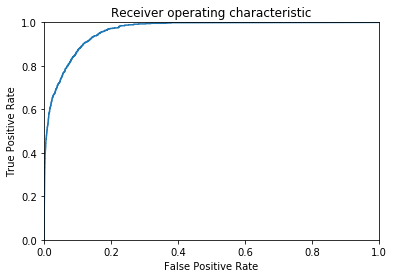

In [80]:
#validation
y_pred_rf_nb_val = rfclassifier_nb.predict(X_val_n)

print("Random Forest classifier non normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val_n,y_pred_rf_nb_val))
print("=== classification_report ===")
print(classification_report(y_val_n,y_pred_rf_nb_val))
print("=== accuracy_score ===")
print(accuracy_score(y_val_n,y_pred_rf_nb_val))

# roc auc  validation dataset

y_pred_rf_nb_val2 = rfclassifier_nb.predict_proba(X_val_n)
y_pred_rf_nb_val2 = [p[1] for p in y_pred_rf_nb_val2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_n,y_pred_rf_nb_val2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_n,y_pred_rf_nb_val2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


feature importance

In [81]:
# important features and visualize them using Seaborn
pd.set_option('display.max_rows',33)
# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = Xnb.columns # no lo hago con resample ver si es correcto
feature_importance['importance'] = rfclassifier_b.feature_importances_

# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head(20)

variable  importance
18                           previous_loans    0.332598
16                                car_years    0.143188
17                              House_years    0.130723
0                                       age    0.089570
13                            amount_rec_0m    0.042354
1                           population_cmun    0.036772
3                  aveg_amount_cred_card_0m    0.029639
7                                    acc_0m    0.024323
14                               num_rec_0m    0.022158
4                           amount_cards_0m    0.021097
5                     amount_total_cards_0m    0.020852
11                               app_par_0m    0.017519
12                               web_par_0m    0.011513
15  aved_amount_postpone_payment_3t4t_delta    0.010613
6                             num_stocks_0m    0.008377
8                                 mobile_0m    0.006665
2                         num_cred_cards_0m    0.005964
9                                     pc_0m    0.005777
29                               mortgage_N    0.004345
22                                studies_3    0.004316

### 6.4 XGBBoost <a class="anchor" id="6.4-bullet"></a>
[table of contents](#index-bullet)

### 6.4.1 XGB non normalized- balanced

In [82]:
# specify parameters and distributions to sample from
warnings.simplefilter('ignore')
'''The randint module will help to initialize random values for the parameters that we want to specify.
It will be clearer after we define the parameter distribution that we want to use in our randomized search.'''

from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [3, 30],
              "max_features": sp_randint(1, X_train_b.shape[1]),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "n_estimators": sp_randint(100, 500)}
        
model_xgb = XGBClassifier(random_state=42)

random_search = RandomizedSearchCV(model_xgb, param_distributions=param_dist,
                                   n_iter=10, cv=3, iid=False, random_state=42)
random_search.fit(X_train_b, y_train_b)
print(random_search.best_params_)

{'bootstrap': True, 'max_depth': 3, 'max_features': 10, 'min_samples_split': 4, 'n_estimators': 463}


[0.90502384 0.90795746 0.91125779 0.91345801 0.9226256  0.91526045
 0.9137931  0.91305943 0.90902421 0.90462216]
XGBoost


=== Confusion Matrix ===
[[5053  171]
 [ 407 1186]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5224
           1       0.87      0.74      0.80      1593

    accuracy                           0.92      6817
   macro avg       0.90      0.86      0.87      6817
weighted avg       0.91      0.92      0.91      6817



=== All AUC Scores ===
[0.90502384 0.90795746 0.91125779 0.91345801 0.9226256  0.91526045
 0.9137931  0.91305943 0.90902421 0.90462216]


=== Mean AUC Score ===
Mean AUC Score - XGBoost:  0.911608205330193
=== roc_curve ===
0.9708418771251331


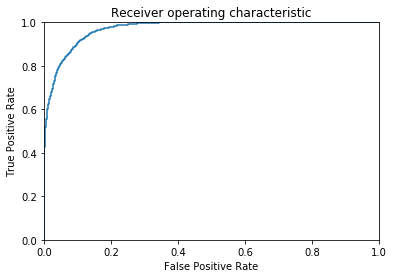

In [83]:
# balanced
warnings.simplefilter('ignore')
model_xgb_b = XGBClassifier(random_state=42,max_depth=3,max_features =9, min_samples_split=4,n_estimators=463)

model_xgb_b.fit(X_train_b,y_train_b)

model_xgb_predict_b = model_xgb_b.predict(X_test_b)

#<<The most important factor behind the success of XGBoost is its scalability in all scenarios. 
#The system runs more than ten times faster than existing popular solutions on a single machine and scales 
#to billions of examples in distributed or memory-limited settings>>.

model_xgb_cv_score_b = cross_val_score(model_xgb_b,  Xb_resampled, yb_resampled, cv=10)

print(model_xgb_cv_score_b)


'''XGBoost'''
print("XGBoost")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_b, model_xgb_predict_b))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_b, model_xgb_predict_b))
print('\n')
print("=== All AUC Scores ===")
print(model_xgb_cv_score_b)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", model_xgb_cv_score_b.mean())

# roc auc  
y_pred_xgb__b2 = model_xgb_b.predict_proba(X_test_b)
y_pred_xgb__b2 = [p[1] for p in y_pred_xgb__b2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_xgb__b2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_xgb__b2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

XGBBoost non normalized balanced validation


=== Confusion Matrix ===
[[37260  1621]
 [  191   522]]
=== classification_report ===
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     38881
           1       0.24      0.73      0.37       713

    accuracy                           0.95     39594
   macro avg       0.62      0.85      0.67     39594
weighted avg       0.98      0.95      0.97     39594

=== accuracy_score ===
0.9542354902257918
=== roc_curve ===
0.9661182159985915


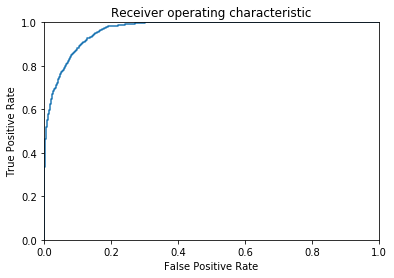

In [84]:
# we need to transform it to matrix to avoid feature mismatch
X_val_xgb = X_val.copy()
y_val_xgb = y_val.copy()
X_val_xgb = X_val_xgb.as_matrix()
y_val_xgb = y_val_xgb.as_matrix()


#validation
y_pred_xgb_b_val = model_xgb_b.predict(X_val_xgb)


print("XGBBoost non normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val_xgb,y_pred_xgb_b_val))
print("=== classification_report ===")
print(classification_report(y_val_xgb,y_pred_xgb_b_val))
print("=== accuracy_score ===")
print(accuracy_score(y_val_xgb,y_pred_xgb_b_val))

# roc auc  

y_pred_xgb_b_val2 = model_xgb_b.predict_proba(X_val_xgb)
y_pred_xgb_b_val2 = [p[1] for p in y_pred_xgb_b_val2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_xgb,y_pred_xgb_b_val2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_xgb,y_pred_xgb_b_val2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

### 6.4.2 XGB normalized- balanced

In [85]:
# specify parameters and distributions to sample from
warnings.simplefilter('ignore')
'''The randint module will help to initialize random values for the parameters that we want to specify.
It will be clearer after we define the parameter distribution that we want to use in our randomized search.'''

from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [3, 30],
              "max_features": sp_randint(1, X_train_nb.shape[1]),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "n_estimators": sp_randint(100, 500)}
        
model_xgb = XGBClassifier(random_state=42)

random_search = RandomizedSearchCV(model_xgb, param_distributions=param_dist,
                                   n_iter=10, cv=3, iid=False, random_state=42)
random_search.fit(X_train_nb, y_train_nb)
print(random_search.best_params_)

{'bootstrap': True, 'max_depth': 3, 'max_features': 9, 'min_samples_split': 8, 'n_estimators': 373}


=== roc_curve ===
0.9669268737941358


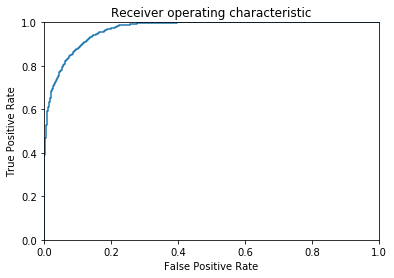

[0.90794058 0.90885751 0.91509261 0.90812397 0.90739043]
XGBoost


=== Confusion Matrix ===
[[5031  193]
 [ 420 1173]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      5224
         1.0       0.86      0.74      0.79      1593

    accuracy                           0.91      6817
   macro avg       0.89      0.85      0.87      6817
weighted avg       0.91      0.91      0.91      6817



=== All AUC Scores ===
[0.90794058 0.90885751 0.91509261 0.90812397 0.90739043]


=== Mean AUC Score ===
Mean AUC Score - XGBoost:  0.9094810196222264
=== roc_curve ===
0.9669268737941358


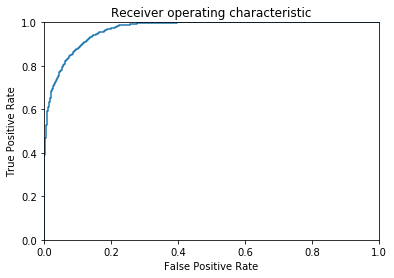

In [86]:
warnings.simplefilter('ignore')
model_xgb_nb = XGBClassifier(random_state=42,max_depth=3,max_features =10, min_samples_split=4,n_estimators=314)
model_xgb_nb.fit(X_train_nb,y_train_nb)
model_xgb_predict_nb = model_xgb_nb.predict(X_test_nb)


model_xgb_cv_score_nb = cross_val_score(model_xgb_nb,  Xnb_resampled, ynb_resampled, cv=5)
# roc auc  

model_xgb_predict_nb2 = model_xgb_nb.predict_proba(X_test_nb)
model_xgb_predict_nb2 = [p[1] for p in model_xgb_predict_nb2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,model_xgb_predict_nb2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,model_xgb_predict_nb2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()
print(model_xgb_cv_score_nb)

'''XGBoost'''
print("XGBoost")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_nb, model_xgb_predict_nb))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_nb, model_xgb_predict_nb))
print('\n')
print("=== All AUC Scores ===")
print(model_xgb_cv_score_nb)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", model_xgb_cv_score_nb.mean())

# roc auc  

model_xgb_predict_nb2 = model_xgb_nb.predict_proba(X_test_nb)
model_xgb_predict_nb2 = [p[1] for p in model_xgb_predict_nb2 ]

print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,model_xgb_predict_nb2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,model_xgb_predict_nb2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

XGBoost normalized balanced validation


=== Confusion Matrix ===
[[37372  1509]
 [  194   519]]
=== classification_report ===
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     38881
         1.0       0.26      0.73      0.38       713

    accuracy                           0.96     39594
   macro avg       0.63      0.84      0.68     39594
weighted avg       0.98      0.96      0.97     39594

=== accuracy_score ===
0.9569884325907966
=== roc_auc_score ===
=== roc_curve ===
0.9673439324860518


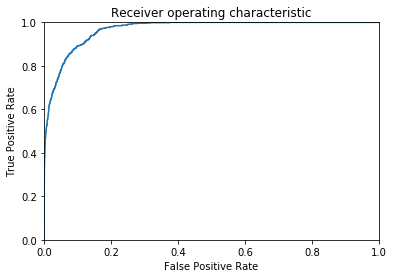

In [87]:
# we need to transform it to matrix to avoid feature mismatch
warnings.simplefilter('ignore')
X_val_xgb_n = X_val_n.copy()
y_val_xgb_n = y_val_n.copy()
X_val_xgb_n = X_val_xgb_n.as_matrix()
y_val_xgb_n = y_val_xgb_n.as_matrix()

#validation
y_pred_b_val_n = model_xgb_nb.predict(X_val_xgb_n)


print("XGBoost normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val_xgb_n,y_pred_b_val_n))
print("=== classification_report ===")
print(classification_report(y_val_xgb_n,y_pred_b_val_n))
print("=== accuracy_score ===")
print(accuracy_score(y_val_xgb_n,y_pred_b_val_n))
print("=== roc_auc_score ===")

# roc auc  

y_pred_b_val_n = model_xgb_nb.predict_proba(X_val_xgb_n)
y_pred_b_val_n = [p[1] for p in y_pred_b_val_n ]  # to avoid error of scalar index
 
print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_xgb_n,y_pred_b_val_n)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_xgb_n,y_pred_b_val_n))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [88]:
# important features and visualize them using Seaborn
pd.set_option('display.max_rows',33)

# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = Xb.columns # no lo hago con resample ver si es correcto
feature_importance['importance'] = model_xgb_b.feature_importances_

# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head(20)

variable  importance
18            previous_loans    0.469792
16                 car_years    0.150044
17               House_years    0.064636
0                        age    0.036271
7                     acc_0m    0.021571
28                 codseg_PI    0.021130
20                 studies_1    0.020199
3   aveg_amount_cred_card_0m    0.019535
8                  mobile_0m    0.018767
24               work_type_J    0.014362
14                num_rec_0m    0.014238
6              num_stocks_0m    0.013607
11                app_par_0m    0.011240
25               work_type_O    0.011120
2          num_cred_cards_0m    0.009863
4            amount_cards_0m    0.009027
22                 studies_3    0.008976
26               work_type_P    0.008959
13             amount_rec_0m    0.008904
29                mortgage_N    0.008025

### 6.5 Stacking ensemble Model <a class="anchor" id="6.5-bullet"></a>
[table of contents](#index-bullet)

### 6.5.1 Balanced

In [89]:
'''it is an ensemble machine learning algorithm.Uses a meta-learning algorithm to learn how 
to best combine the predictions from two or more base machine learning algorithms.The outputs 
are probability values in the case of classification.'''

warnings.simplefilter('ignore')

sclf = StackingClassifier(classifiers=[model_logreg_b,dt_clients_file_num_b,rfclassifier_b],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=model_xgb_b)

print('3-fold cross validation:\n')

for clf, label in zip([model_logreg_b,dt_clients_file_num_b,rfclassifier_b,sclf], 
                      ['lg', 
                       'dt', 
                       'rf',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train_b, y_train_b, 
                                              cv=3, scoring='roc_auc')
    print("roc_auc: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

roc_auc: 0.60 (+/- 0.00) [lg]
roc_auc: 0.90 (+/- 0.00) [dt]
roc_auc: 0.96 (+/- 0.00) [rf]
roc_auc: 0.90 (+/- 0.02) [StackingClassifier]


Stack model balanced


=== Confusion Matrix ===
[[4997  227]
 [ 374 1219]]
=== classification_report ===
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      5224
           1       0.84      0.77      0.80      1593

    accuracy                           0.91      6817
   macro avg       0.89      0.86      0.87      6817
weighted avg       0.91      0.91      0.91      6817

=== accuracy_score ===
0.911838051929001
=== roc_curve ===
0.9336881590495939


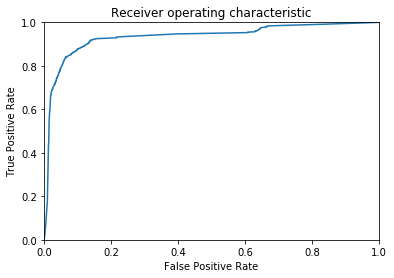

In [91]:

# test
warnings.simplefilter('ignore')
sclf.fit(X_train_b, y_train_b)
preds_stack1 = sclf.predict(X_test_b)

print("Stack model balanced")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_b,preds_stack1))
print("=== classification_report ===")
print(classification_report(y_test_b,preds_stack1))
print("=== accuracy_score ===")
print(accuracy_score(y_test_b,preds_stack1))

# roc auc  

# we need to transform it to matrix to avoid feature mismatch

y_pred_b_stack1 = sclf.predict_proba(X_test_b)
y_pred_b_stack1 = [p[1] for p in y_pred_b_stack1]  # to avoid error of scalar index
 
print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_b_stack1)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_b_stack1))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

Stack balanced validation


=== Confusion Matrinstack,y_pred_b_val_stack
=== classification_report ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     38881
           1       0.21      0.75      0.32       713

    accuracy                           0.94     39594
   macro avg       0.60      0.85      0.65     39594
weighted avg       0.98      0.94      0.96     39594

=== accuracy_score ===
0.9434762842854978
=== roc_curve ===
0.8500610324169267


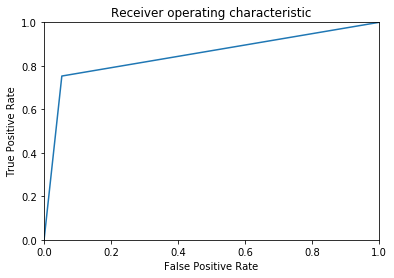

In [92]:
# validation

# we need to transform it to matrix to avoid feature mismatch
X_val_stack1 = X_val.copy()
y_val_stack1 = y_val.copy()
X_val_stack1 = X_val_stack1.as_matrix()
y_val_stack1 = y_val_stack1.as_matrix()

y_pred_b_val_stack1= sclf.predict(X_val_stack1)

print("Stack balanced validation")
print('\n')
print("=== Confusion Matrinstack,y_pred_b_val_stack")
print("=== classification_report ===")
print(classification_report(y_val_stack1,y_pred_b_val_stack1))
print("=== accuracy_score ===")
print(accuracy_score(y_val_stack1,y_pred_b_val_stack1))

# roc auc  

# we need to transform it to matrix to avoid feature mismatch

y_pred_b_stack1 = sclf.predict_proba(X_val_stack1)
y_pred_b_stack1 = [p[1] for p in y_pred_b_stack1] # to avoid error of scalar index
 
print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_stack1,y_pred_b_val_stack1)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_stack1,y_pred_b_val_stack1))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

### 6.5.2 Normalized-balanced

3-fold cross validation:

roc_auc: 0.88 (+/- 0.00) [lg]
roc_auc: 0.90 (+/- 0.00) [dt]
roc_auc: 0.96 (+/- 0.00) [rf]
roc_auc: 0.87 (+/- 0.02) [StackingClassifier]
Stack model normalized balanced


=== Confusion Matrix ===
[[4929  295]
 [ 353 1240]]
=== classification_report ===
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94      5224
         1.0       0.81      0.78      0.79      1593

    accuracy                           0.90      6817
   macro avg       0.87      0.86      0.87      6817
weighted avg       0.90      0.90      0.90      6817

=== accuracy_score ===
0.9049435235440809
=== roc_curve ===
0.9130839819885813


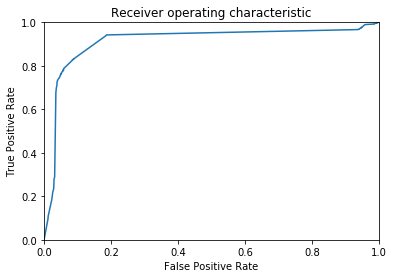

In [93]:
warnings.simplefilter('ignore')

sclf = StackingClassifier(classifiers=[model_logreg_nb,dt_clients_file_num_nb,rfclassifier_nb],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=model_xgb_nb)

print('3-fold cross validation:\n')

for clf, label in zip([model_logreg_nb,dt_clients_file_num_nb,rfclassifier_nb,sclf], 
                      ['lg', 
                       'dt', 
                       'rf',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train_nb, y_train_nb, 
                                              cv=3, scoring='roc_auc')
    print("roc_auc: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))
    
sclf.fit(X_train_nb, y_train_nb)
preds_stack1_nb = sclf.predict(X_test_nb)
# test
print("Stack model normalized balanced")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_nb,preds_stack1_nb))
print("=== classification_report ===")
print(classification_report(y_test_nb,preds_stack1_nb))
print("=== accuracy_score ===")
print(accuracy_score(y_test_nb,preds_stack1_nb))

# roc auc  

# we need to transform it to matrix to avoid feature mismatch

y_pred_nb_stack1= sclf.predict_proba(X_test_nb)
y_pred_nb_stack1 = [p[1] for p in y_pred_nb_stack1]  # to avoid error of scalar index
 
print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,y_pred_nb_stack1)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,y_pred_nb_stack1))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

Stack balanced validation


=== Confusion Matrix ===
[[36449  2432]
 [  153   560]]
=== classification_report ===
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97     38881
         1.0       0.19      0.79      0.30       713

    accuracy                           0.93     39594
   macro avg       0.59      0.86      0.63     39594
weighted avg       0.98      0.93      0.95     39594

=== accuracy_score ===
0.9347123301510329
=== roc_curve ===
0.9093019939685059


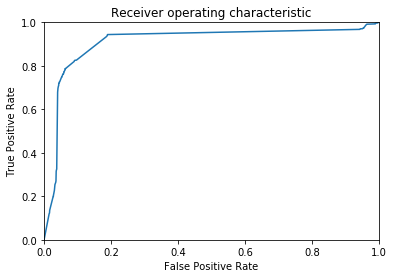

In [94]:
# validation

# we need to transform it to matrix to avoid feature mismatch
X_val_stack1_n = X_val_n.copy()
y_val_stack1_n = y_val_n.copy()
X_val_stack1_n = X_val_stack1_n.as_matrix()
y_val_stack1_n = y_val_stack1_n.as_matrix()

y_pred_val_stack1_n= sclf.predict(X_val_stack1_n)

print("Stack balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val_stack1_n,y_pred_val_stack1_n))
print("=== classification_report ===")
print(classification_report(y_val_stack1_n,y_pred_val_stack1_n))
print("=== accuracy_score ===")
print(accuracy_score(y_val_stack1_n,y_pred_val_stack1_n))

# roc auc  

# we need to transform it to matrix to avoid feature mismatch

y_pred_val_stack1_n2 = sclf.predict_proba(X_val_stack1_n)
y_pred_val_stack1_n2 = [p[1] for p in y_pred_val_stack1_n2] # to avoid error of scalar index
 
print("=== roc_curve ===")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val_stack1_n,y_pred_val_stack1_n2)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val_stack1_n,y_pred_val_stack1_n2))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

### 7 Business Plan  <a class="anchor" id="seventh-bullet"></a>
[table of contents](#index-bullet)

### 7.1 Initial approach and basic information <a class="anchor" id="7.1-bullet"></a>
[table of contents](#index-bullet)

In [95]:
# Extract validation dataset to CSV to carry the Business case study
'''With the Business Plan, the two main questions of this work will be answered.
  - Why the "black box"model is predicting a client over another?
  - How can the results help build rapport with the client?'''
'''Basic assumptions are created to be able to build a Business case using the validation prediction dataset'''
'''All the analysis will be carry out with an excel sheet-prediction_results_analysis.csv'''
res = pd.DataFrame(y_pred_b_stack1,columns=['got_loan_predict']).reset_index()
clients_pred_X = pd.DataFrame(X_val,columns=total_clients_mod_.columns[1:]).reset_index()
clients_pred_y = pd.DataFrame(y_val,columns=['got_loan']).reset_index()
prediction_real = pd.concat([clients_pred_y,res,clients_pred_X],axis =1)
prediction_real.to_csv("prediction_results.csv",sep=';')

### 7.2 Implementing LIME to generate local interpretations of black-box  <a class="anchor" id="7.2-bullet"></a>
Locally Interpretable Model-Agnostic Explanations ( implemented for Random Forest, XGBoost & Stacking ensemble models)

[table of contents](#index-bullet)

In [96]:
X_val2=  pd.DataFrame(X_val,columns =X_train.columns)
y_val2=  pd.DataFrame(y_val,columns =y_test.columns)

In [97]:

explainer = LimeTabularExplainer(X_val2.values, mode="classification", feature_names=X_train)

In [98]:
# storing a new observation
i = X_val2.index.get_loc(361160)
X_observation = X_val2.iloc[[i], :]
    
X_observation

age  population_cmun  num_cred_cards_0m  aveg_amount_cred_card_0m  \
361160   57          25042.0                  1                     -57.1   

        amount_cards_0m  amount_total_cards_0m  num_stocks_0m  acc_0m  \
361160         172.1118               237.3084              0      17   

        mobile_0m  pc_0m  tablet_0m  app_par_0m  web_par_0m  amount_rec_0m  \
361160        1.0    0.0        0.0          16           1      828.30728   

        num_rec_0m  aved_amount_postpone_payment_3t4t_delta  car_years  \
361160          12                                      0.0         10   

        House_years  previous_loans  gender_V  studies_1  studies_2  \
361160           23               0         0          1          0   

        studies_3  work_type_A  work_type_J  work_type_O  work_type_P  \
361160          0            1            0            0            0   

        codseg_PB  codseg_PI  mortgage_N  
361160          0          0           1

In [99]:
# check the full information into the original file 
pd.set_option('display.max_columns', 61)
index_called = 361160 
# 1554   

real_data = Total_clients_ini.loc[ index_called , : ].to_frame().T
real_data

cod1    cod2 gender age nat_country resi_country studies work_type  \
361160    C  243821      H  57          ES           ES       1         A   

       branch marital_status codseg  cpper cprovper clocaper autonper country  \
361160   6753              O     PR  18010       28      347        1      ES   

       codine population_cmun disporent_cmun num_cred_cards_0m  \
361160  41091         25042.0          26732                 1   

       aveg_amount_cred_card_0m num_current_acc_0m aveg_amount_current_acc_0m  \
361160                    -57.1                  1                      78.43   

       num_invest_funds_0m aveg_amount_invest_funds_0m mortgage num_stocks_0m  \
361160                   0                           0        N             0   

       aveg_amount_stocks_0m acc_0m mobile_0m pc_0m tablet_0m  \
361160                     0     17       1.0   0.0       0.0   

       national_transfers_0m transfers_0m app_par_0m web_par_0m  \
361160                     1            0         16          1   

       amount_cards_0m amount_trfr_0m amount_salarypenr_0m amount_rec_0m  \
361160        172,1118       1318,456            1376,4652     828,30728   

       amount_total_cards_0m num_trfr_0m num_trfe_0m num_rec_0m  \
361160              237,3084           2           0         12   

       num_card_postpone_payment_3t4t_delta  \
361160                                    0   

       aved_amount_postpone_payment_3t4t_delta previous_loans  \
361160                                       0              0   

       months_since_loan car_years House_years got_loan  
361160               NaN        10          23        1

In [100]:
# Explanations using LIME  with the random forest model

explanation = explainer.explain_instance(X_observation.values[0], rfclassifier_b.predict_proba)
explanation.show_in_notebook(show_table=True, show_all=False)


In [101]:
# Detail by feature
explanation.as_list()

[('car_years > 9.00', 0.19813869493540748),
 ('previous_loans <= 0.00', -0.18768351097118485),
 ('16.00 < House_years <= 32.00', 0.1347809418147864),
 ('app_par_0m > 10.00', 0.022149477286908945),
 ('aved_amount_postpone_payment_3t4t_delta <= 0.00', -0.020216289795299252),
 ('acc_0m > 15.00', 0.015461622716401918),
 ('0.19 < mobile_0m <= 1.00', 0.015132216910991684),
 ('studies_1 > 0.00', 0.01497351706311451),
 ('46.00 < age <= 58.00', -0.014078974156202653),
 ('0.00 < amount_total_cards_0m <= 290.78', -0.01180459986987197)]

In [102]:
# Explanations using LIME  with the XGB model

explanation_xgb = explainer.explain_instance(X_observation.values[0], model_xgb_b.predict_proba)
explanation_xgb.show_in_notebook(show_table=True, show_all=False)

In [103]:
# Detail by feature
explanation_xgb.as_list()

[('previous_loans <= 0.00', -0.2554698026616473),
 ('car_years > 9.00', 0.19122818909943237),
 ('16.00 < House_years <= 32.00', 0.12828868322010206),
 ('aved_amount_postpone_payment_3t4t_delta <= 0.00', -0.051526862256513005),
 ('codseg_PB <= 0.00', 0.049521889317760366),
 ('aveg_amount_cred_card_0m <= 0.00', 0.041234329823602575),
 ('codseg_PI <= 0.00', 0.032522012391060305),
 ('app_par_0m > 10.00', 0.02886368460830419),
 ('acc_0m > 15.00', 0.019811507614003708),
 ('work_type_O <= 0.00', 0.01962820685278231)]

In [106]:
# Explanations using LIME  with the stacking model

explanation_stack = explainer.explain_instance(X_observation.values[0],sclf.predict_proba)
explanation_stack.show_in_notebook(show_table=True, show_all=False)

In [105]:
# Detail by feature
explanation_stack.as_list()


[('previous_loans <= 0.00', 0.3267684479004124),
 ('work_type_P <= 0.00', 0.020695686850333524),
 ('codseg_PI <= 0.00', 0.017058333032642956),
 ('acc_0m > 15.00', 0.016095308487372312),
 ('codseg_PB <= 0.00', 0.015593958369375025),
 ('car_years > 9.00', 0.015437016038565093),
 ('16.00 < House_years <= 32.00', 0.014322005626865012),
 ('tablet_0m <= 0.00', 0.011987335473750986),
 ('pc_0m <= 0.00', 0.00972791459414564),
 ('app_par_0m > 10.00', 0.00789816538586865)]